# Bayesian Analysis of Factors Affecting Student Performance
Dataset : https://data.mendeley.com/datasets/5b82ytz489/1
Note: The dataset column name "Overall" is the output variable CGPA


# Install cmdstanpy

In [ ]:
!pip3 install cmdstanpy
import cmdstanpy
cmdstanpy.install_cmdstan()
from cmdstanpy import install_cmdstan
install_cmdstan()


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


CmdStan install directory: /root/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


CmdStan install directory: /root/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


True

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import cmdstanpy
import arviz as az
from patsy import dmatrix
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Visualization  

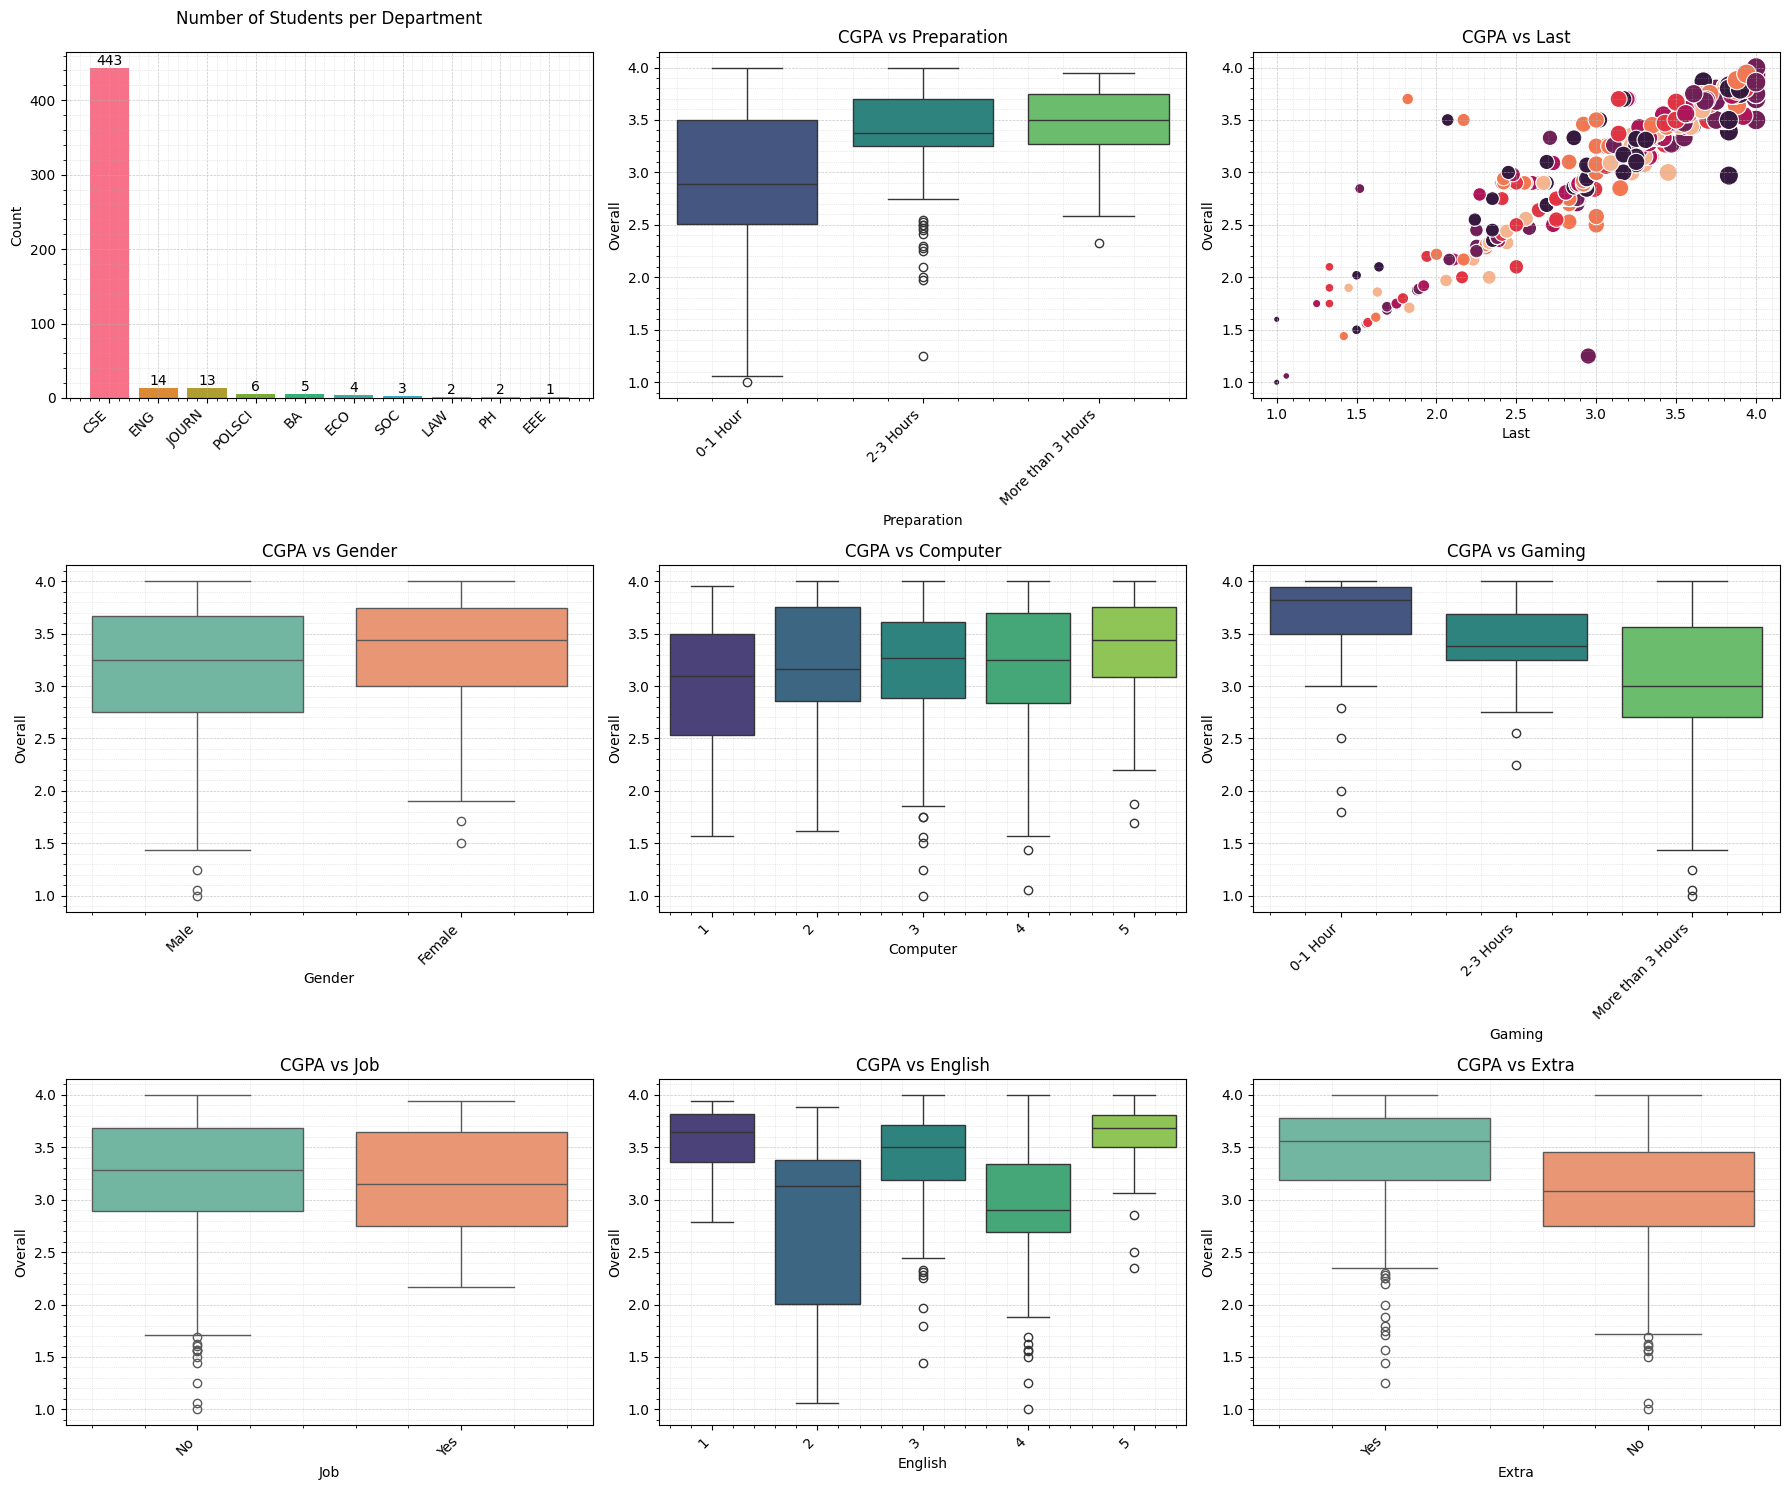

In [ ]:
# Load data & Visualize key predictors

data = pd.read_csv('data.csv')

# Department name abbreviations
dept_mapping = {
    'Computer Science and Engineering': 'CSE',
    'Electrical and Electronic Engineering': 'EEE',
    'Business Administration': 'BA',
    'Economics': 'ECO',
    'Sociology': 'SOC',
    'Law and Human Rights': 'LAW',
    'Public Health': 'PH',
    'Journalism, Communication and Media Studies': 'JOURN',
    'Political Science': 'POLSCI',
    'English': 'ENG'
}
data['Department'] = data['Department'].map(dept_mapping).fillna(data['Department'])

# Define your feature categories
features = ["Preparation", "Last", "Gender", "Computer", "Gaming", "Job", "English", "Extra"]
target = "Overall"

nominal_cols = ['Gender', 'Job', 'Extra', 'Department']  # Added Department
ordinal_cols = ['Computer', 'Preparation', 'Gaming', 'English']
numeric_cols = ['Last']

# Set up the subplot grid - adding 1 for the department count plot
n_cols = 3
n_rows = ((len(features) + 1) + n_cols - 1) // n_cols  # +1 for department plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

# Create a color palette
nominal_palette = sns.color_palette("Set2")
ordinal_palette = sns.color_palette("viridis")
numeric_palette = sns.color_palette("rocket")

# First plot - Department Count
ax = axes[0]
dept_counts = data['Department'].value_counts().sort_values(ascending=False)

# Create bar plot with different colors
bars = ax.bar(dept_counts.index, dept_counts.values,
              color=sns.color_palette("husl", len(dept_counts)))

# Add grid lines
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
ax.minorticks_on()

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}',
            ha='center', va='bottom')

ax.set_title("Number of Students per Department", pad=20)
ax.set_ylabel("Count")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Remaining feature plots

for i, feature in enumerate(features, start=1):  # Start at 1 to leave space for dept plot
    ax = axes[i]

    # Add grid lines
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
    ax.minorticks_on()

    if feature in nominal_cols:
        unique_values = data[feature].nunique()
        palette = nominal_palette[:unique_values] if unique_values <= len(nominal_palette) else nominal_palette
        sns.boxplot(data=data, x=feature, y=target, ax=ax, palette=palette)
        ax.set_title(f"CGPA vs {feature}")

    elif feature in ordinal_cols:
        unique_values = data[feature].nunique()
        palette = sns.color_palette("viridis", unique_values)
        sns.boxplot(data=data, x=feature, y=target, ax=ax, palette=palette, order=sorted(data[feature].unique()))
        ax.set_title(f"CGPA vs {feature}")

    elif feature in numeric_cols:
        sns.scatterplot(data=data, x=feature, y=target, ax=ax, palette=numeric_palette,
                        hue=feature,size=feature, sizes=(20, 200))
        ax.set_title(f"CGPA vs {feature}")
        ax.legend().remove()

    if feature in nominal_cols or feature in ordinal_cols:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=0.5, h_pad=0.3, w_pad=0.2)

plt.tight_layout()
plt.show()
# plt.savefig("All_visuals.pdf", dpi = 300) # To save the plot in pdf format comment out plt.show(), otherwise it won't be saved

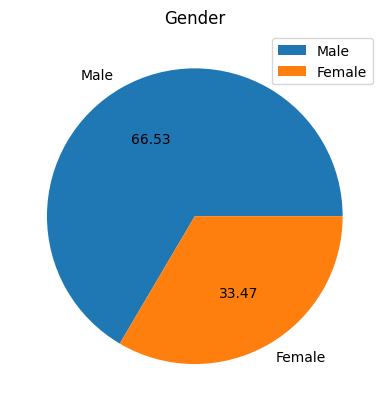

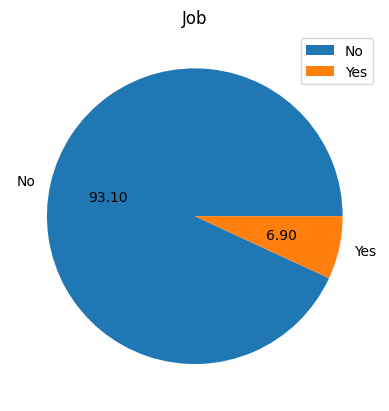

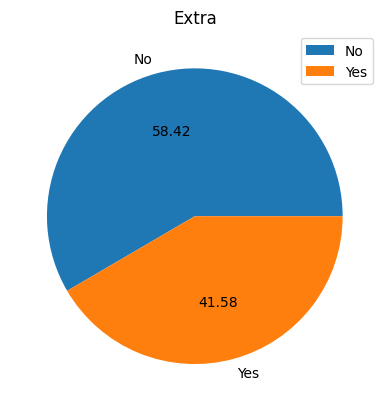

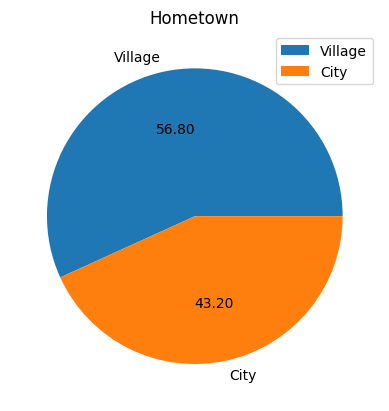

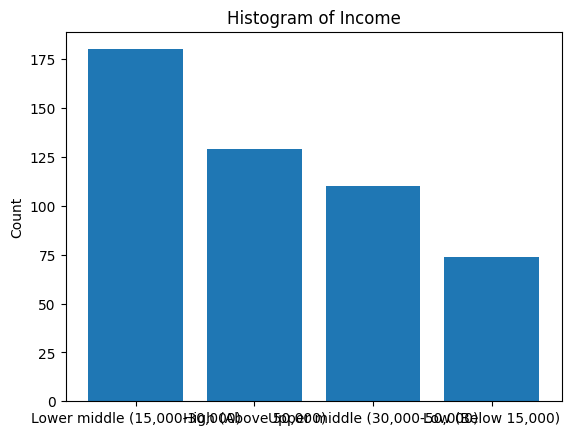

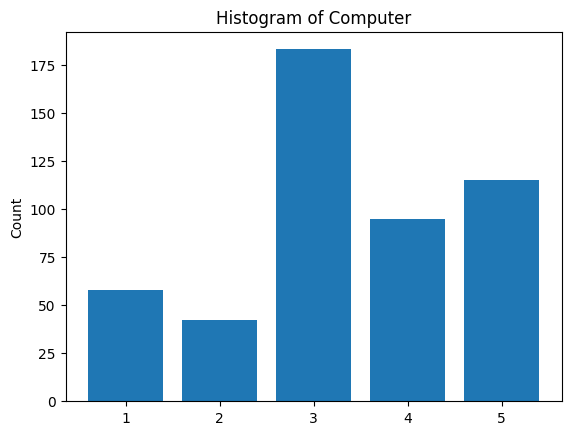

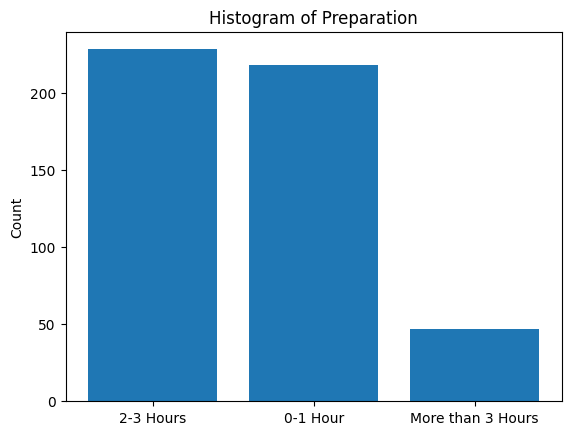

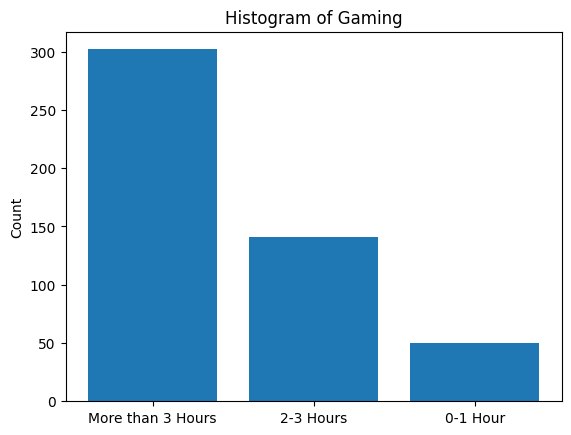

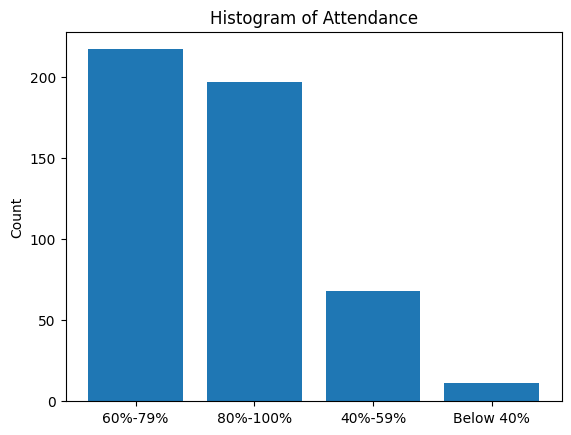

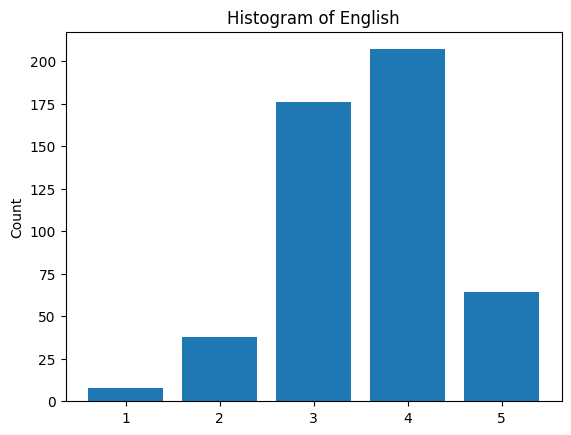

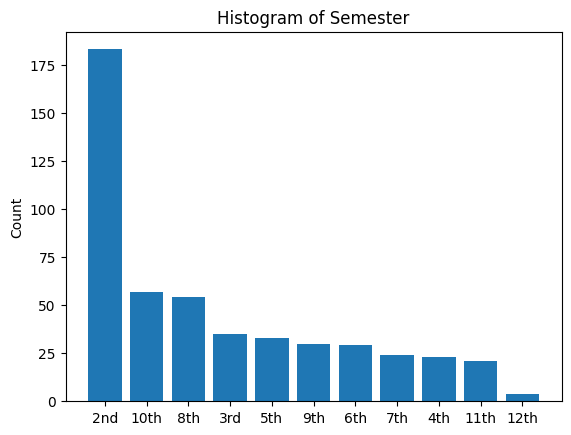

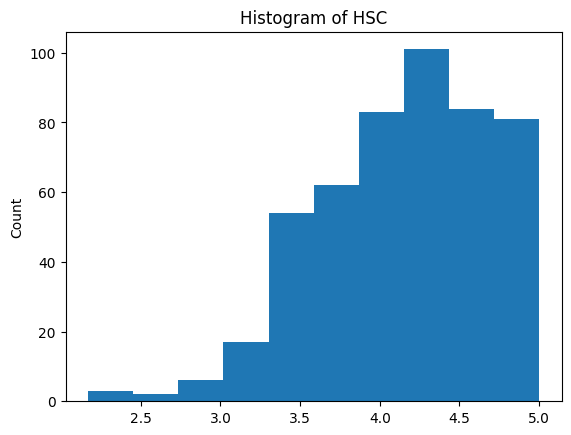

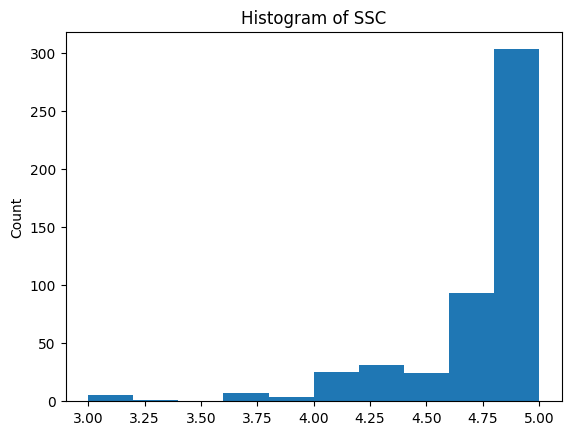

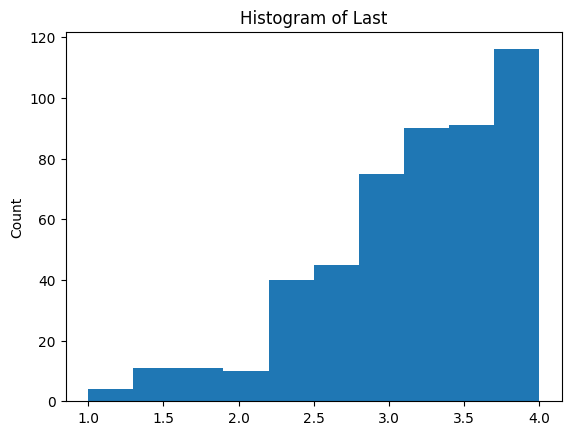

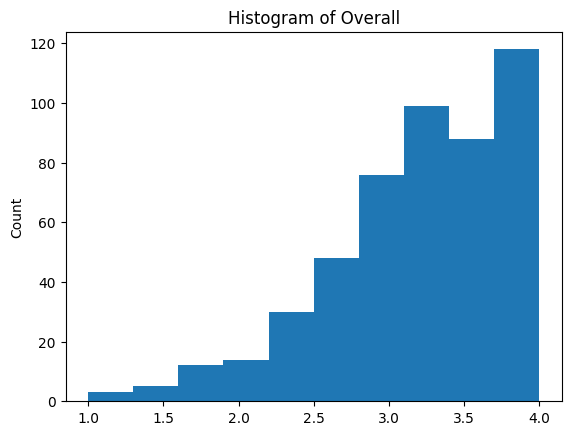

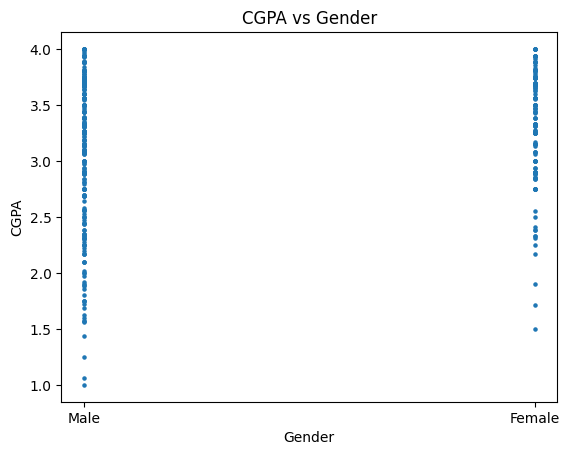

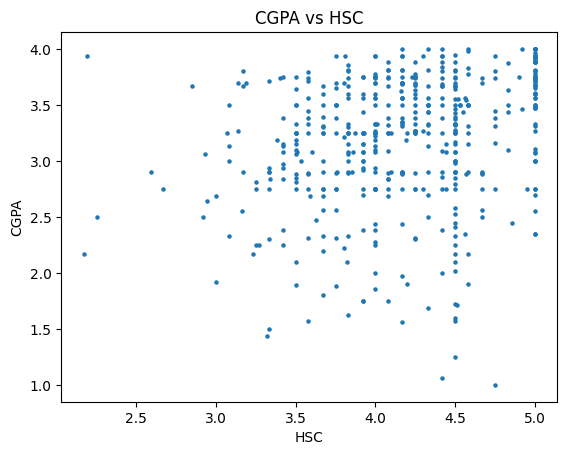

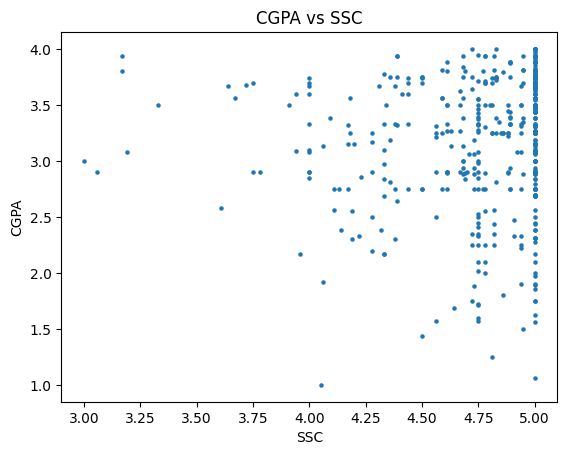

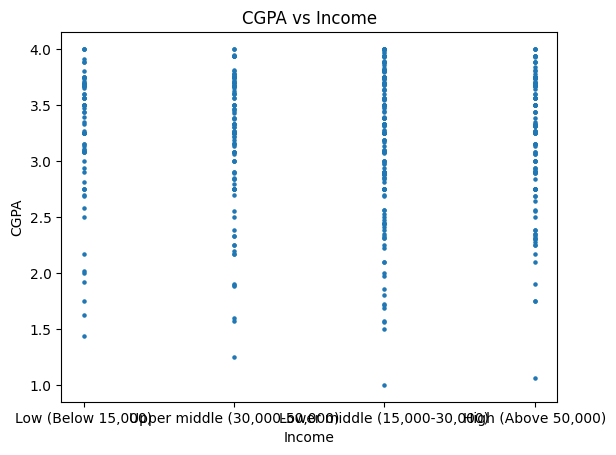

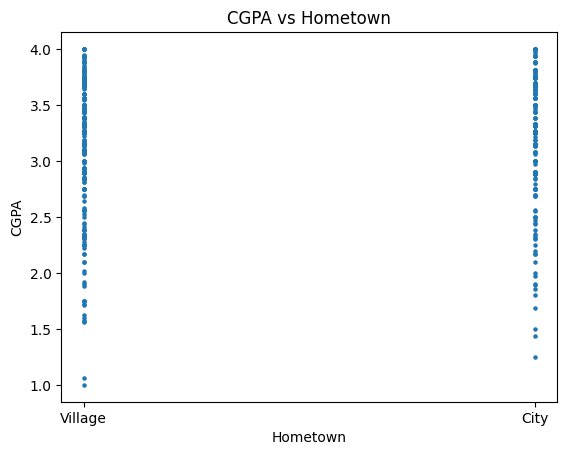

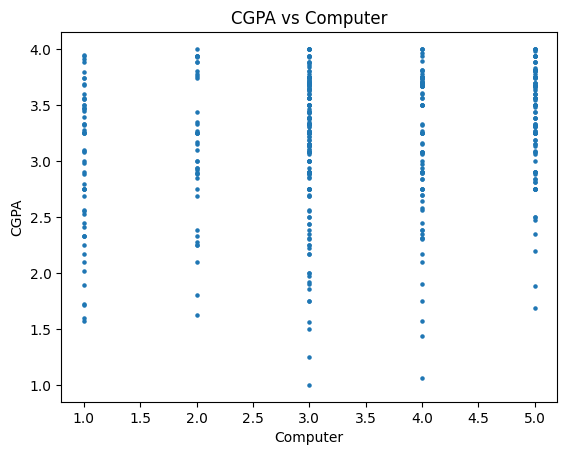

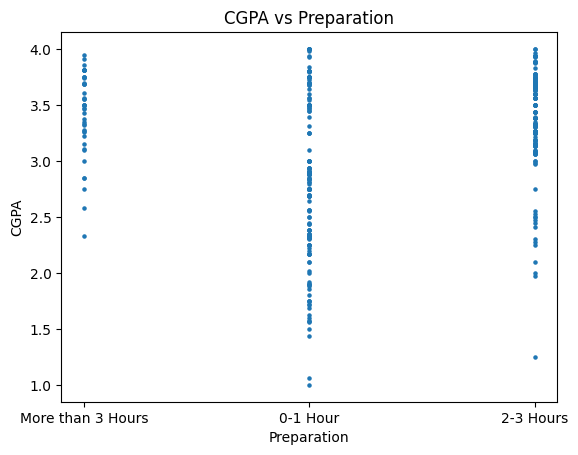

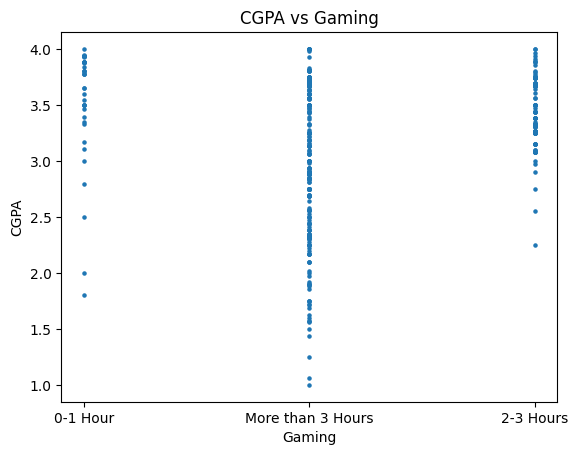

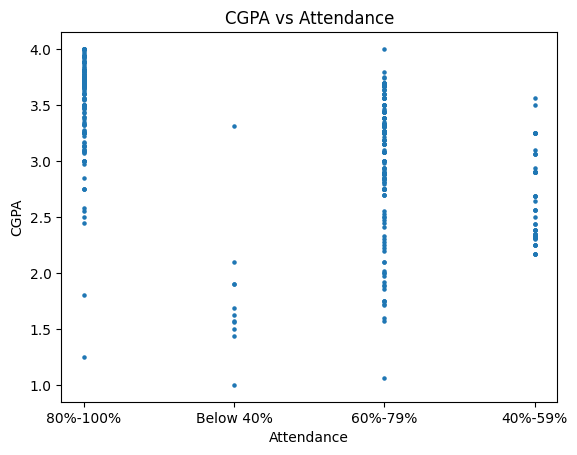

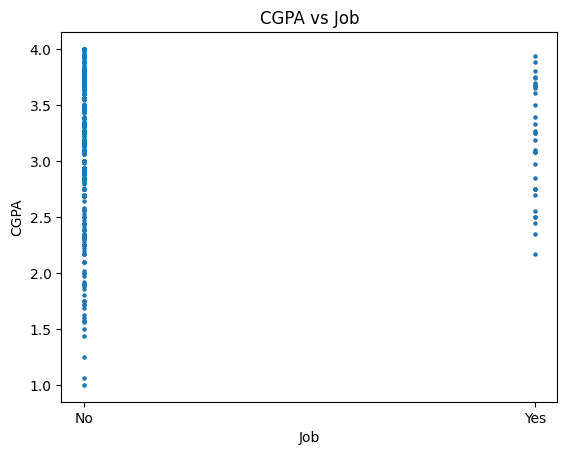

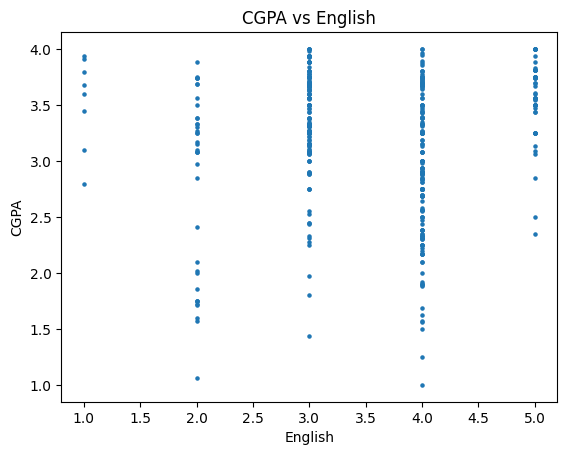

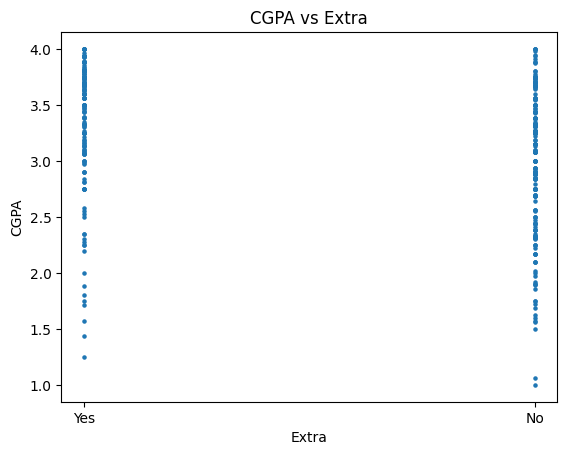

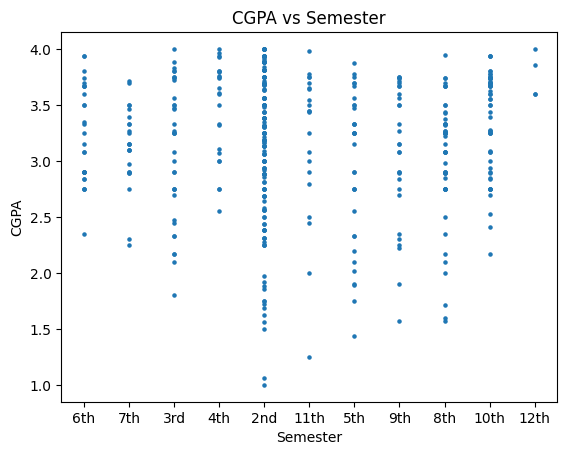

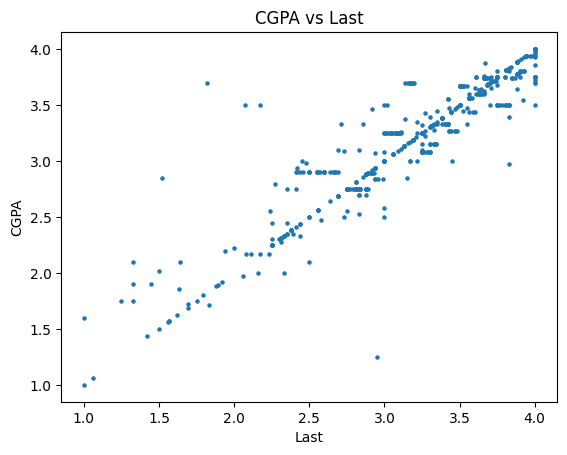

In [ ]:
# #Visualizing nominal data: Department, Gender, Hometown, Job, Extra

# drop insignificant department column

data = data.drop(columns=["Department"])

# separating different column types
nominal_cols = ['Gender', 'Job', 'Extra', 'Hometown']
ordinal_cols = ['Income', 'Computer', 'Preparation', 'Gaming', 'Attendance', 'English', 'Semester']
numeric_cols = ['HSC', 'SSC', 'Last', 'Overall']

# Strip whitespace
data['Income'] = data['Income'].str.strip()

# plt.figure(figsize = (35,10))
# plt.title("Number of students by department")
# plt.bar(data["Department"].value_counts().index, data["Department"].value_counts())
# plt.show()

for feature in nominal_cols:
    if feature!= "Department":
        plt.title(feature)
        plt.pie(data[feature].value_counts(), labels = data[feature].value_counts().index.to_list(), autopct = "%.2f")
        plt.legend()
        plt.show()

#Visualizing ordinal data: Income, Computer, Preparation, Gaming, Attendance, English, Semester

for feature in ordinal_cols:
    plt.title("Histogram of "+feature)
    plt.ylabel("Count")
    plt.bar(data[feature].value_counts().index.to_list(), data[feature].value_counts())
    plt.show()

#Visualizing numeric data: HSC, SSC, Last, Overall

for feature in numeric_cols:
    plt.title("Histogram of "+feature)
    plt.ylabel("Count")
    plt.hist(data[feature])
    plt.show()

#CGPA plotted against each feature
for col in data.columns:
    if col!= "Overall":
        plt.title("CGPA vs "+ col)
        plt.xlabel(col)
        plt.ylabel("CGPA")
        plt.scatter(data[col],data["Overall"], s = 5)
        plt.show()

# Data Preprocessing

In [ ]:
# One-hot encode nominal categorical variables
data = pd.get_dummies(data, columns = nominal_cols, drop_first = True)

# Mapping for the ordinal variables: Income, Preparation, Gaming, Semester, Attendance
income_mapping = {
    "Low (Below 15,000)": 1,
    "Lower middle (15,000-30,000)": 2,
    "Upper middle (30,000-50,000)": 3,
    "High (Above 50,000)": 4
}
data['Income'] = data['Income'].map(income_mapping)

# Mapping study preparation time and gaming time to numeric values.
prep_mapping = {
    "0-1 Hour": 1,
    "2-3 Hours": 2,
    "More than 3 Hours": 3
}
data['Preparation'] = data['Preparation'].map(prep_mapping)
data['Gaming'] = data['Gaming'].map(prep_mapping)

# Convert strings in Semester column like "6th", "7th", etc. to integers.
data['Semester'] = data['Semester'].str.extract('(\d+)').astype(int)

# Mapping attendance ranges to numeric values
attendance_mapping = {
    "80%-100%": 4,
    "60%-79%": 3,
    "40%-59%": 2,
    "Below 40%": 1
}

# Apply the mapping to the Attendance column.
data['Attendance'] = data['Attendance'].str.strip().map(attendance_mapping)

# Use the .replace() method to map True/False to 1/0
data = data.replace({True: 1, False: 0})

# Columns to scale (features only, excluding 'Overall')
cols_to_scale = ['HSC', 'SSC', 'Last']

# Initialize separate scalers
feature_scaler = StandardScaler()  # For features (HSC, SSC, Last)
target_scaler = StandardScaler()   # For target (Overall)

# Scale the features (modifies HSC, SSC, Last in-place)
data[cols_to_scale] = feature_scaler.fit_transform(data[cols_to_scale])

# Scale 'Overall' and add as a new column (without affecting the original)
data['Overall_scaled'] = target_scaler.fit_transform(data[['Overall']])

# Create descriptive statistics table
#Variance
stats_data = data.describe()
variance = pd.DataFrame([data.var()])
variance = variance.rename(index = {0:"variance"})
#median
median = pd.DataFrame([data.median()])
median = median.rename(index = {0:"median"})
#skew
skew = pd.DataFrame([data.skew()])
skew = skew.rename(index = {0:"skew"})
#kurtois
kurtosis = pd.DataFrame([data.kurtosis()])
kurtosis = kurtosis.rename(index = {0:"kurtosis"})

stats = pd.concat([stats_data, variance, median, skew, kurtosis])
stats = stats.drop(columns=["Overall_scaled","Overall"], axis = 1)
stats


,HSC,SSC,Income,Computer,Preparation,Gaming,Attendance,English,Semester,Last,Gender_Male,Job_Yes,Extra_Yes,Hometown_Village
count,4.930000e+02,4.930000e+02,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,4.930000e+02,493.000000,493.000000,493.000000,493.000000
mean,1.729516e-16,-2.331243e-15,2.596349,3.338742,1.653144,2.511156,3.217039,3.569980,5.316430,2.306021e-16,0.665314,0.068966,0.415822,0.567951
std,1.001016e+00,1.001016e+00,1.032671,1.252988,0.646579,0.673525,0.762133,0.870515,3.259956,1.001016e+00,0.472360,0.253653,0.493364,0.495864
min,-3.639119e+00,-5.062237e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,-3.376730e+00,0.000000,0.000000,0.000000,0.000000
25%,-5.985442e-01,-2.510061e-01,2.000000,3.000000,1.000000,2.000000,3.000000,3.000000,2.000000,-5.522400e-01,0.000000,0.000000,0.000000,0.000000
50%,2.422413e-02,4.935892e-01,2.000000,3.000000,2.000000,3.000000,3.000000,4.000000,5.000000,1.343764e-01,1.000000,0.000000,0.000000,1.000000
75%,6.286757e-01,6.654189e-01,4.000000,4.000000,2.000000,3.000000,4.000000,4.000000,8.000000,7.897829e-01,1.000000,0.000000,1.000000,1.000000
max,1.544511e+00,6.654189e-01,4.000000,5.000000,3.000000,3.000000,4.000000,5.000000,12.000000,1.304745e+00,1.000000,1.000000,1.000000,1.000000
variance,1.002033e+00,1.002033e+00,1.066409,1.569980,0.418064,0.453635,0.580847,0.757796,10.627311,1.002033e+00,0.223124,0.064340,0.243408,0.245881
median,2.422413e-02,4.935892e-01,2.000000,3.000000,2.000000,3.000000,3.000000,4.000000,5.000000,1.343764e-01,1.000000,0.000000,0.000000,1.000000


# Helper Functions

In [ ]:
# Function to calculate Rsquared values

def Rsquared(y_pred, y_true):

    residual_sum_squares = np.sum((y_true - y_pred)**2)
    total_sum_squares = np.sum((y_true - np.mean(y_true))**2)

    Rsquared = 1- residual_sum_squares/total_sum_squares

    return Rsquared

# Function to plot regression result

def plot_regression(plot_title, data, pred_overall):

    # Scatter plot to compare actual vs predicted GPA
    plt.figure(figsize=(8, 4))
    plt.scatter(data["Overall_scaled"], pred_overall, alpha=0.4, color="blue", label="Predicted Scaled CGPA")
    plt.scatter(data["Overall_scaled"], data["Overall_scaled"], alpha=0.4, color="red", label="Actual Scaled CGPA")  # Plot actual values in red
    plt.xlabel("Actual Scaled CGPA")
    plt.ylabel("Predicted Scaled CGPA")
    plt.title(plot_title)
    plt.grid()
    plt.legend()
    plt.show()

# Model with all factors (no interaction)

In [ ]:
#Dictionary to store the Rsquared values for each model
R_squared_vals = {}

In [ ]:
'''Index(['HSC', 'SSC', 'Income', 'Computer', 'Preparation', 'Gaming',
       'Attendance', 'English', 'Semester', 'Last', 'Overall', 'Gender_Female',
       'Gender_Male', 'Job_No', 'Job_Yes', 'Extra_No', 'Extra_Yes',
       'Hometown_City', 'Hometown_Village', 'Overall_scaled'],
      dtype='object')'''

predictor_cols = [col for col in data.columns if col not in ["Overall_scaled", "Overall"]]
K_value = data.drop(columns=["Overall_scaled", "Overall"]).shape[1]

# Create a dictionary to pass data to Stan
stan_data_all = {
   "N": data.shape[0],
   "K": K_value,
   "X": data.drop(columns=["Overall_scaled", "Overall"]).values,
   "Y": data["Overall_scaled"].values
}

# Stan model code to save in a file

full_model = """
data {
  // data size
  int<lower=0> N;
  int<lower=0> K;

  // target variable
  vector[N] Y;

  // predictors
  matrix[N, K] X;
}

parameters {
    vector[K] beta;      // Regression coefficients
    real alpha;          // Intercept
    real<lower=0> sigma; // Error term
}
model {
  // priors

  alpha ~ normal(0,10);
  beta ~ normal(0,10);
  sigma ~ normal(0,10);

  // model
  // Likelihood function
  Y ~ normal(X*beta + alpha, sigma);
}
"""
# save model in stan file
stan_model_file = "all_factor_regression.stan"
with open(stan_model_file, "w") as f:
    f.write(full_model)

# Compile and run Stan model

stan_full_model = cmdstanpy.CmdStanModel(stan_file = stan_model_file)
fit_full = stan_full_model.sample(data = stan_data_all, chains=4, iter_sampling=2000, iter_warmup=1000, seed=42)

# Posterior Analysis & Visualization
fit_full.summary().to_csv("full_stan_results.csv")
fit_full.summary()

DEBUG:cmdstanpy:Removing /content/all_factor_regression
05:27:41 - cmdstanpy - INFO - compiling stan file /content/all_factor_regression.stan to exe file /content/all_factor_regression
INFO:cmdstanpy:compiling stan file /content/all_factor_regression.stan to exe file /content/all_factor_regression
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=all_factor_regression.stan /content/all_factor_regression
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=all_factor_regression.stan --o=/content/all_factor_regression.hpp /content/all_factor_regression.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/all_factor_regression', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/azkoc04m.json', 'output', 'file=/tmp/tmphw84p3wo/all_factor_regressionu7e0dity/all_factor_regression-20250328052809_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/all_factor_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/azkoc04m.json', 'output', 'file=/tmp/tmphw84p3wo/all_factor_regressionu7e0dity/all_factor_regression-20250328052809_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/all_factor_regression', 'id=3', 'random', 'seed=42', 'data', 

05:28:22 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/all_factor_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/azkoc04m.json', 'output', 'file=/tmp/tmphw84p3wo/all_factor_regressionu7e0dity/all_factor_regression-20250328052809_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/all_factor_regressionu7e0dity/all_factor_regression-20250328052809_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/all_factor_regressionu7e0dity/all_factor_regression-20250328052809_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      en

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-all_factor_regression-s2r_y0o9.csv /tmp/tmphw84p3wo/all_factor_regressionu7e0dity/all_factor_regression-20250328052809_1.csv /tmp/tmphw84p3wo/all_factor_regressionu7e0dity/all_factor_regression-20250328052809_2.csv /tmp/tmphw84p3wo/all_factor_regressionu7e0dity/all_factor_regression-20250328052809_3.csv /tmp/tmphw84p3wo/all_factor_regressionu7e0dity/all_factor_regression-20250328052809_4.csv
cwd: None


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,230.203000,0.051331,2.853580,2.765050,224.979000,230.507000,234.269000,3173.16,5032.35,1.002670
beta[1],0.027945,0.000183,0.019904,0.019460,-0.004979,0.027654,0.060819,11932.50,6176.90,1.000440
beta[2],-0.006557,0.000178,0.018612,0.018446,-0.037116,-0.006351,0.023837,11010.90,6002.37,1.000430
beta[3],0.008827,0.000174,0.017504,0.017683,-0.019535,0.008810,0.037199,10255.30,5638.56,0.999815
beta[4],0.018968,0.000147,0.014940,0.014947,-0.005566,0.019058,0.043918,10418.30,6538.02,1.000180
beta[5],0.062497,0.000295,0.029375,0.028948,0.013923,0.062416,0.110803,10035.50,5590.22,1.000120
beta[6],0.004107,0.000316,0.030467,0.030447,-0.045532,0.004378,0.053676,9306.36,6416.37,1.000770
beta[7],0.030445,0.000419,0.033663,0.033818,-0.025471,0.030384,0.086329,6499.17,6047.12,1.000200
beta[8],-0.008446,0.000216,0.022110,0.022202,-0.044988,-0.008298,0.028102,10609.90,5224.56,1.000220
beta[9],-0.001360,0.000045,0.005354,0.005467,-0.010043,-0.001325,0.007345,14580.20,5708.35,1.000520


R squared for model with all factors (no interaction):  0.8606793687757909


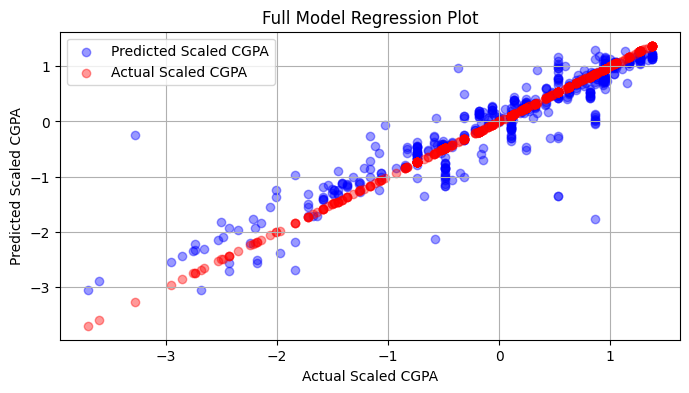

In [ ]:
full_posterior_samples = fit_full.draws_pd()

# Extract posterior means for coefficients and intercept
full_beta_means = full_posterior_samples[[col for col in full_posterior_samples.columns if "beta" in col]].mean().values
full_alpha_mean = full_posterior_samples["alpha"].mean()

# Compute predicted GPA using the regression formula
pred_overall_full = data.drop(columns=["Overall_scaled", "Overall"]).dot(full_beta_means) + full_alpha_mean

# Compute Rsquare value
R_squared_full = Rsquared(y_pred = pred_overall_full, y_true = data["Overall_scaled"])
print("R squared for model with all factors (no interaction): ", R_squared_full)
R_squared_vals["all_factors"] = round(R_squared_full,3)

# Plot regression line
plot_regression("Full Model Regression Plot", data, pred_overall_full)

In [ ]:
# Check for divergences
divergences = full_posterior_samples['divergent__']
print("Number of divergences:", divergences.sum())

Number of divergences: 0.0


# Academic Model

In [ ]:
academic_cols = ['HSC', 'SSC','Preparation', 'Attendance', 'Semester', 'Last', 'Overall_scaled']
data_academic = data[academic_cols]
K_value = data_academic.drop(columns=["Overall_scaled"]).shape[1]

# Create a dictionary to pass data to Stan
stan_data_academic = {
   "N": data_academic.shape[0],
   "K": K_value,
   "X": data_academic.drop(columns=["Overall_scaled"]).values,
   "Y": data_academic["Overall_scaled"].values
}

# Stan model code to save in a file
# efficient way to write the stan model program

academic_model = """
data {
  // data size
  int<lower=0> N;
  int<lower=0> K;

  // target variable
  vector[N] Y;

  // predictors
  matrix[N, K] X;
}

parameters {
    vector[K] beta;      // Regression coefficients
    real alpha;          // Intercept
    real<lower=0> sigma; // Error term
}
model {
  // priors

  alpha ~ normal(0,10);
  beta ~ normal(0,10);
  sigma ~ normal(0,10);

  // model
  // Likelihood function
  Y ~ normal(X*beta + alpha, sigma);
}
"""

# save model in stan file
stan_model_file = "student_performance_regression.stan"
with open(stan_model_file, "w") as f:
    f.write(academic_model)

# Compile and run Stan model
stan_academic_model = cmdstanpy.CmdStanModel(stan_file = stan_model_file)
fit_academic = stan_academic_model.sample(data = stan_data_academic, chains=4, iter_sampling=2000, iter_warmup=1000, seed=42)

# Posterior Analysis & Visualization
fit_academic.summary().to_csv("academic_stan_results.csv")
fit_academic.summary()

DEBUG:cmdstanpy:Removing /content/student_performance_regression
05:28:23 - cmdstanpy - INFO - compiling stan file /content/student_performance_regression.stan to exe file /content/student_performance_regression
INFO:cmdstanpy:compiling stan file /content/student_performance_regression.stan to exe file /content/student_performance_regression
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=student_performance_regression.stan /content/student_performance_regression
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=student_performance_regression.stan --o=/content/student_performance_regression.hpp /content/student_performance_regression.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/student_performance_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/2ea9zbok.json', 'output', 'file=/tmp/tmphw84p3wo/student_performance_regressionc9_7ln6a/student_performance_regression-20250328052841_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/student_performance_regression', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/2ea9zbok.json', 'output', 'file=/tmp/tmphw84p3wo/student_performance_regressionc9_7ln6a/student_performance_regression-20250328052841_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/student

05:28:49 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/student_performance_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/2ea9zbok.json', 'output', 'file=/tmp/tmphw84p3wo/student_performance_regressionc9_7ln6a/student_performance_regression-20250328052841_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/student_performance_regressionc9_7ln6a/student_performance_regression-20250328052841_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/student_performance_regressionc9_7ln6a/student_performance_regression-20250328052841_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup = 1000 (Default)
    save_war

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-student_performance_regression-adtl7mmx.csv /tmp/tmphw84p3wo/student_performance_regressionc9_7ln6a/student_performance_regression-20250328052841_1.csv /tmp/tmphw84p3wo/student_performance_regressionc9_7ln6a/student_performance_regression-20250328052841_2.csv /tmp/tmphw84p3wo/student_performance_regressionc9_7ln6a/student_performance_regression-20250328052841_3.csv /tmp/tmphw84p3wo/student_performance_regressionc9_7ln6a/student_performance_regression-20250328052841_4.csv
cwd: None


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,231.403000,0.033570,2.025450,1.888090,227.613000,231.745000,234.071000,3711.40,5071.77,1.000060
beta[1],0.026201,0.000240,0.019274,0.019175,-0.005323,0.026095,0.057743,6487.28,5646.79,1.000380
beta[2],-0.009388,0.000225,0.018095,0.018149,-0.039103,-0.009362,0.020172,6498.87,5773.58,0.999838
beta[3],0.071285,0.000353,0.029766,0.029658,0.022595,0.071388,0.119529,7106.55,5721.40,0.999981
beta[4],0.032437,0.000523,0.030681,0.030408,-0.017742,0.032323,0.082342,3466.23,4828.79,0.999971
beta[5],-0.001291,0.000054,0.005354,0.005334,-0.010133,-0.001370,0.007440,9848.19,5717.87,0.999965
beta[6],0.886544,0.000351,0.022929,0.022988,0.848698,0.886623,0.923654,4300.25,5173.22,0.999841
alpha,-0.215482,0.001791,0.103610,0.102312,-0.387044,-0.215006,-0.044640,3357.62,4084.61,1.000040
sigma,0.379240,0.000135,0.012482,0.012511,0.359415,0.379063,0.400295,8622.43,6225.64,1.000080


R squared for model with academic factors (no interaction):  0.8606793687757909


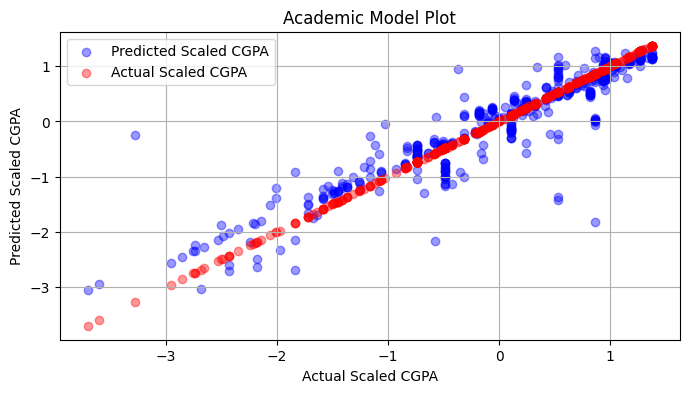

In [ ]:
# Extract posterior samples
academic_posterior_samples = fit_academic.draws_pd()

# Extract posterior means for coefficients and intercept
academic_beta_means = academic_posterior_samples[[col for col in academic_posterior_samples.columns if "beta" in col]].mean().values
academic_alpha_mean = academic_posterior_samples["alpha"].mean()

# Compute predicted GPA using the regression formula
pred_overall_academic = data_academic.drop(columns=["Overall_scaled"]).dot(academic_beta_means) + academic_alpha_mean

# Compute Rsquare value
R_squared_academic = Rsquared(y_pred = pred_overall_full, y_true = data_academic["Overall_scaled"])
print("R squared for model with academic factors (no interaction): ", R_squared_academic)
R_squared_vals["academic"] = round(R_squared_academic,3)

# Plot regression line
plot_regression("Academic Model Plot", data_academic, pred_overall_academic)


# Academic interactions

In [ ]:
'''academic_cols = [
    'HSC', 'SSC','Preparation', 'Attendance', 'Semester', 'Last', 'Overall', 'Overall_scaled'
    ]''' # Added for easy reference to the columns

# Create interaction terms
X_ac = dmatrix('~ 0 + Preparation + Attendance + Last + Last:Preparation + Preparation:Attendance + Last:Attendance',
             data_academic,
             return_type='dataframe')

# Prepare Stan data for interaction effect
stan_data = {
    "N": X_ac.shape[0],
    "K": X_ac.shape[1],
    "X": X_ac.values,
    "Y": data_academic["Overall_scaled"].values
}

academic_interaction_model = """
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N, K] X;
  vector[N] Y;
}
parameters {
  real alpha;
  vector[K] beta;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);
  sigma ~ normal(0, 10);

  Y ~ normal(alpha + X * beta, sigma);
}
"""
# save model in stan file
stan_model_file = 'interaction_effects_academic_model.stan'
with open(stan_model_file, "w") as f:
    f.write(academic_interaction_model)
stan_model = cmdstanpy.CmdStanModel(stan_file=stan_model_file)
fit_academic_inter = stan_model.sample(data=stan_data, chains=4, iter_sampling=2000, iter_warmup=1000, seed=42)

# Posterior Analysis & Visualization
fit_academic_inter.summary().to_csv("academic_interaction_stan_results.csv")
fit_academic_inter.summary()

DEBUG:cmdstanpy:Removing /content/interaction_effects_academic_model
05:28:50 - cmdstanpy - INFO - compiling stan file /content/interaction_effects_academic_model.stan to exe file /content/interaction_effects_academic_model
INFO:cmdstanpy:compiling stan file /content/interaction_effects_academic_model.stan to exe file /content/interaction_effects_academic_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=interaction_effects_academic_model.stan /content/interaction_effects_academic_model
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=interaction_effects_academic_model.stan --o=/content/interaction_effects_academic_model.hpp /content/interaction_effects_academic_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/interaction_effects_academic_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/pk1apw8d.json', 'output', 'file=/tmp/tmphw84p3wo/interaction_effects_academic_model8yf5xnl4/interaction_effects_academic_model-20250328052908_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/interaction_effects_academic_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/pk1apw8d.json', 'output', 'file=/tmp/tmphw84p3wo/interaction_effects_academic_model8yf5xnl4/interaction_effects_academic_model-20250328052908_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan 

05:29:32 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/interaction_effects_academic_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/pk1apw8d.json', 'output', 'file=/tmp/tmphw84p3wo/interaction_effects_academic_model8yf5xnl4/interaction_effects_academic_model-20250328052908_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/interaction_effects_academic_model8yf5xnl4/interaction_effects_academic_model-20250328052908_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/interaction_effects_academic_model8yf5xnl4/interaction_effects_academic_model-20250328052908_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup =

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-interaction_effects_academic_model-bt5co_r1.csv /tmp/tmphw84p3wo/interaction_effects_academic_model8yf5xnl4/interaction_effects_academic_model-20250328052908_1.csv /tmp/tmphw84p3wo/interaction_effects_academic_model8yf5xnl4/interaction_effects_academic_model-20250328052908_2.csv /tmp/tmphw84p3wo/interaction_effects_academic_model8yf5xnl4/interaction_effects_academic_model-20250328052908_3.csv /tmp/tmphw84p3wo/interaction_effects_academic_model8yf5xnl4/interaction_effects_academic_model-20250328052908_4.csv
cwd: None


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,237.836000,0.036022,1.984640,1.911810,234.148000,238.143000,240.487000,3124.82,4531.53,1.00059
alpha,0.136664,0.007853,0.313243,0.310201,-0.370235,0.131917,0.650974,1595.14,2447.44,1.00261
beta[1],-0.119175,0.004492,0.183461,0.179323,-0.421849,-0.117721,0.181269,1673.05,2692.76,1.00217
beta[2],-0.074455,0.002225,0.089606,0.087932,-0.222602,-0.072762,0.073977,1627.67,2585.30,1.00209
beta[3],1.128610,0.002135,0.092797,0.093426,0.976108,1.129200,1.280920,1891.62,2810.00,1.00142
beta[4],-0.130734,0.000677,0.037954,0.037843,-0.192605,-0.131215,-0.067210,3129.61,3661.10,1.00095
beta[5],0.061669,0.001272,0.051872,0.051058,-0.023757,0.061394,0.146857,1668.50,2687.71,1.00237
beta[6],-0.015726,0.000405,0.022510,0.022667,-0.052391,-0.015581,0.020633,3102.22,3502.36,1.00074
sigma,0.374028,0.000165,0.011815,0.011699,0.355192,0.373614,0.393715,5116.17,4849.39,1.00085


R squared for academic interactive model:  0.8626571210684335


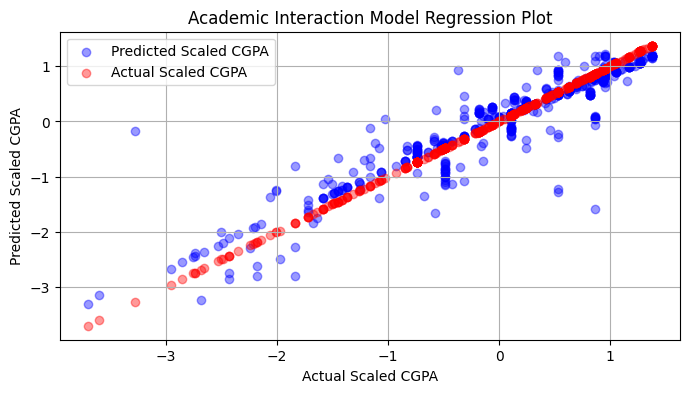

In [ ]:
# Extract posterior samples
academic_posterior_samples_inter = fit_academic_inter.draws_pd()

# Extract posterior means for coefficients and intercept
academic_beta_means_inter = academic_posterior_samples_inter[[col for col in academic_posterior_samples_inter.columns if "beta" in col]].mean().values
academic_alpha_mean_inter = academic_posterior_samples_inter["alpha"].mean()

# Compute predicted GPA using the regression formula
# pred_overall_academic_inter = data_academic.drop(columns=["Overall_scaled"]).dot(academic_beta_means_inter) + academic_alpha_mean_inter
pred_overall_academic_inter = X_ac.dot(academic_beta_means_inter) + academic_alpha_mean_inter

# Compute Rsquare value
R_squared_academic_inter = Rsquared(y_pred = pred_overall_academic_inter, y_true = data_academic["Overall_scaled"])
print("R squared for academic interactive model: ", R_squared_academic_inter)
R_squared_vals["academic_inter"] = round(R_squared_academic_inter,3)

# Plot regression line
plot_regression("Academic Interaction Model Regression Plot", data_academic, pred_overall_academic_inter)

# Non-Academic Model

In [ ]:
non_academic_cols=['Gender_Male','Income','Hometown_Village','Computer','Gaming','Job_Yes','English','Extra_Yes','Overall_scaled'] #consider the features after one hot encoding
data_non_academic = data[non_academic_cols]

K_value = data_non_academic.drop(columns=["Overall_scaled"]).shape[1]

# Create a dictionary to pass data to Stan
stan_data_main_effects = {
   "N": data_non_academic.shape[0],
   "K": K_value,
   "X": data_non_academic.drop(columns=["Overall_scaled"]).values,
   "Y": data_non_academic["Overall_scaled"].values
}

# Stan file code
non_academic_model = """
data {
  // data size
  int<lower=0> N;
  int<lower=0> K;

  // target variable
  vector[N] Y;

  // predictors
  matrix[N, K] X;
}

parameters {
    vector[K] beta;      // Regression coefficients
    real alpha;          // Intercept
    real<lower=0> sigma; // Error term
}
model {
  // priors

  alpha ~ normal(0, 10);         // Intercept centered around 3
  beta ~ normal(0, 10);          // Effects expected to be modest
  sigma ~ normal(0, 10);       // Supports small sigma values

  // model
  // Likelihood function
  Y ~ normal(X*beta + alpha, sigma);
}
"""

# save model in stan file
stan_model_file = "non_academic_student_performance_regression.stan"
with open(stan_model_file, "w") as f:
    f.write(non_academic_model)

stan_non_academic_model = cmdstanpy.CmdStanModel(stan_file = stan_model_file)
fit_non_academic = stan_non_academic_model.sample(data = stan_data_main_effects, chains=4, iter_sampling=2000, iter_warmup=1000, seed=42)

# Posterior Analysis & Visualization
fit_non_academic.summary().to_csv("non_academic_stan_results.csv")
fit_non_academic.summary()

DEBUG:cmdstanpy:Removing /content/non_academic_student_performance_regression
05:29:33 - cmdstanpy - INFO - compiling stan file /content/non_academic_student_performance_regression.stan to exe file /content/non_academic_student_performance_regression
INFO:cmdstanpy:compiling stan file /content/non_academic_student_performance_regression.stan to exe file /content/non_academic_student_performance_regression
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=non_academic_student_performance_regression.stan /content/non_academic_student_performance_regression
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=non_academic_student_performance_regression.stan --o=/content/non_academic_student_performance_regression.hpp /content/non_academic_student_performance_regression.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memacces

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/non_academic_student_performance_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/ew38x4o4.json', 'output', 'file=/tmp/tmphw84p3wo/non_academic_student_performance_regressionpltpx9hl/non_academic_student_performance_regression-20250328052952_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/non_academic_student_performance_regression', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/ew38x4o4.json', 'output', 'file=/tmp/tmphw84p3wo/non_academic_student_performance_regressionpltpx9hl/non_academic_student_performance_regression-20250328052952_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:ru

05:30:00 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/non_academic_student_performance_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/ew38x4o4.json', 'output', 'file=/tmp/tmphw84p3wo/non_academic_student_performance_regressionpltpx9hl/non_academic_student_performance_regression-20250328052952_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/non_academic_student_performance_regressionpltpx9hl/non_academic_student_performance_regression-20250328052952_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/non_academic_student_performance_regressionpltpx9hl/non_academic_student_performance_regression-20250328052952_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sa

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-non_academic_student_performance_regression-ht0q0r8c.csv /tmp/tmphw84p3wo/non_academic_student_performance_regressionpltpx9hl/non_academic_student_performance_regression-20250328052952_1.csv /tmp/tmphw84p3wo/non_academic_student_performance_regressionpltpx9hl/non_academic_student_performance_regression-20250328052952_2.csv /tmp/tmphw84p3wo/non_academic_student_performance_regressionpltpx9hl/non_academic_student_performance_regression-20250328052952_3.csv /tmp/tmphw84p3wo/non_academic_student_performance_regressionpltpx9hl/non_academic_student_performance_regression-20250328052952_4.csv
cwd: None


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-168.980000,0.035981,2.281750,2.153480,-173.150000,-168.632000,-165.854000,3935.22,4887.27,1.000590
beta[1],-0.326687,0.000950,0.082818,0.083155,-0.461794,-0.326130,-0.190389,7638.32,6090.67,1.000590
beta[2],-0.017673,0.000474,0.037856,0.037581,-0.079312,-0.017406,0.043874,6402.45,5817.47,1.000610
beta[3],0.032753,0.001023,0.082359,0.082488,-0.102869,0.033035,0.167776,6516.54,6000.72,1.000490
beta[4],0.107949,0.000394,0.032119,0.032391,0.055642,0.108005,0.161194,6654.53,5531.28,1.000430
beta[5],-0.602818,0.000775,0.062534,0.062744,-0.705306,-0.602499,-0.499110,6528.08,5781.07,0.999885
beta[6],-0.138731,0.001703,0.154339,0.153807,-0.392987,-0.140279,0.115595,8293.70,5856.03,1.000320
beta[7],0.166110,0.000623,0.048207,0.048873,0.086364,0.166098,0.244195,6008.69,5554.32,1.000720
beta[8],0.478187,0.000937,0.079430,0.078869,0.346853,0.478619,0.608177,7310.71,6062.28,1.000250
alpha,0.616179,0.003816,0.244573,0.242601,0.220144,0.614308,1.015870,4123.16,5369.29,0.999703


R squared for model with non-academic factors (no interactions):  0.28525752590396325


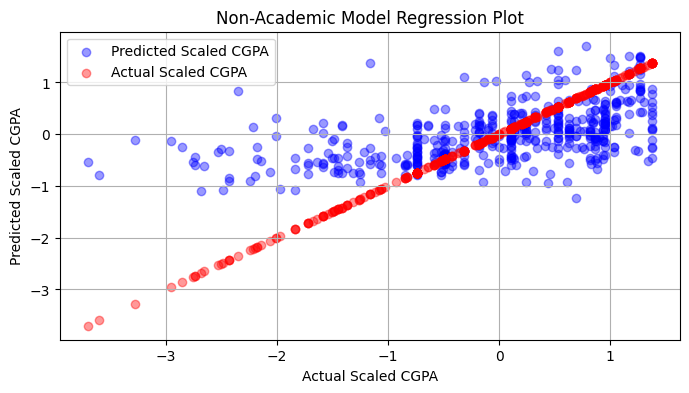

In [ ]:
# Extract posterior samples
non_academic_posterior_samples = fit_non_academic.draws_pd()

# Extract posterior means for coefficients and intercept
non_academic_beta_means = non_academic_posterior_samples[[col for col in non_academic_posterior_samples.columns if "beta" in col]].mean().values
non_academic_alpha_mean = non_academic_posterior_samples["alpha"].mean()

# Compute predicted GPA using the regression formula
pred_overall_non_academic = data_non_academic.drop(columns=["Overall_scaled"]).dot(non_academic_beta_means) + non_academic_alpha_mean

# Compute Rsquare value
R_squared_non_academic = Rsquared(y_pred = pred_overall_non_academic, y_true = data_non_academic["Overall_scaled"])
print("R squared for model with non-academic factors (no interactions): ", R_squared_non_academic)
R_squared_vals["non_academic"] = round(R_squared_non_academic,3)

# Plot regression line
plot_regression("Non-Academic Model Regression Plot", data_non_academic, pred_overall_non_academic)

# Non-academic Interactions

In [ ]:
# Create interaction terms
X_nac = dmatrix('~ 0 + Gender_Male + Computer + Gaming + Extra_Yes + English + Gender_Male:Gaming + Computer:Gaming + Gaming:Extra_Yes + Computer:Extra_Yes + Gender_Male:Extra_Yes + Gender_Male:English',
             data_non_academic,
             return_type='dataframe')

# Prepare Stan data for interaction effect
stan_data = {
    "N": X_nac.shape[0],
    "K": X_nac.shape[1],
    "X": X_nac.values,
    "Y": data_non_academic["Overall_scaled"].values
}

non_academic_interaction_model = """
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N, K] X;
  vector[N] Y;
}
parameters {
  real alpha;
  vector[K] beta;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(0,10);
  beta ~ normal(0, 10);
  sigma ~ normal(0,10);

  Y ~ normal(alpha + X * beta, sigma);
}
"""
# save model in stan file
stan_model_file = 'interaction_effects_model.stan'
with open(stan_model_file, "w") as f:
    f.write(non_academic_interaction_model)
stan_model = cmdstanpy.CmdStanModel(stan_file=stan_model_file)
fit_non_acad_inter = stan_model.sample(data=stan_data, chains=4, iter_sampling=2000, iter_warmup=1000, seed=42)

# Posterior Analysis & Visualization
fit_non_acad_inter.summary().to_csv("non_academic_interaction_stan_results.csv")
fit_non_acad_inter.summary()

DEBUG:cmdstanpy:Removing /content/interaction_effects_model
05:30:01 - cmdstanpy - INFO - compiling stan file /content/interaction_effects_model.stan to exe file /content/interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/interaction_effects_model.stan to exe file /content/interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=interaction_effects_model.stan /content/interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=interaction_effects_model.stan --o=/content/interaction_effects_model.hpp /content/interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eige

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/l0vc9tui.json', 'output', 'file=/tmp/tmphw84p3wo/interaction_effects_model5zl10hgd/interaction_effects_model-20250328053019_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/l0vc9tui.json', 'output', 'file=/tmp/tmphw84p3wo/interaction_effects_model5zl10hgd/interaction_effects_model-20250328053019_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/interaction_effects_model', 'id=3', '

05:30:47 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/l0vc9tui.json', 'output', 'file=/tmp/tmphw84p3wo/interaction_effects_model5zl10hgd/interaction_effects_model-20250328053019_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/interaction_effects_model5zl10hgd/interaction_effects_model-20250328053019_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/interaction_effects_model5zl10hgd/interaction_effects_model-20250328053019_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-interaction_effects_model-dels6q7z.csv /tmp/tmphw84p3wo/interaction_effects_model5zl10hgd/interaction_effects_model-20250328053019_1.csv /tmp/tmphw84p3wo/interaction_effects_model5zl10hgd/interaction_effects_model-20250328053019_2.csv /tmp/tmphw84p3wo/interaction_effects_model5zl10hgd/interaction_effects_model-20250328053019_3.csv /tmp/tmphw84p3wo/interaction_effects_model5zl10hgd/interaction_effects_model-20250328053019_4.csv
cwd: None


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-158.056000,0.045336,2.556250,2.390690,-162.765000,-157.701000,-154.519000,3303.66,4618.43,1.00079
alpha,1.793920,0.010111,0.576148,0.580534,0.851506,1.790320,2.744540,3255.58,4725.13,1.00050
beta[1],-0.373141,0.005333,0.396785,0.398340,-1.016470,-0.372841,0.281072,5556.83,5553.97,1.00001
beta[2],0.009844,0.002133,0.126273,0.126035,-0.201394,0.011378,0.220713,3495.35,4584.98,1.00049
beta[3],-0.975188,0.003527,0.198907,0.198971,-1.305410,-0.971746,-0.653280,3173.07,4477.27,1.00089
beta[4],-0.852256,0.005784,0.385367,0.384535,-1.490900,-0.850405,-0.224152,4455.23,4735.77,1.00032
beta[5],0.111054,0.001053,0.078193,0.078646,-0.019607,0.112157,0.236656,5624.67,5302.48,1.00089
beta[6],-0.094444,0.001729,0.129513,0.128927,-0.310215,-0.092974,0.117653,5659.70,5932.47,1.00017
beta[7],0.030575,0.000742,0.045322,0.044550,-0.043987,0.030115,0.105633,3724.88,5054.59,1.00038
beta[8],0.559516,0.001561,0.116700,0.117932,0.367626,0.559858,0.752200,5640.44,5725.13,1.00063


R squared for model with non-academic factors (with interactions):  0.320402527016725


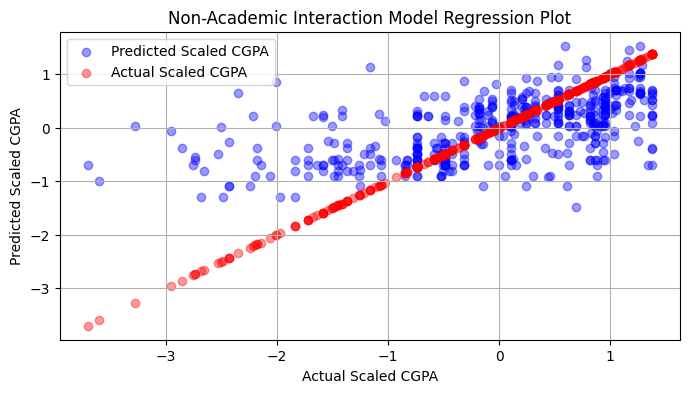

In [ ]:
# Extract posterior samples
non_acad_posterior_samples_inter = fit_non_acad_inter.draws_pd()

# Extract posterior means for coefficients and intercept
non_acad_beta_means_inter = non_acad_posterior_samples_inter[[col for col in non_acad_posterior_samples_inter.columns if "beta" in col]].mean().values
non_acad_alpha_mean_inter = non_acad_posterior_samples_inter["alpha"].mean()

# Compute predicted GPA using the regression formula
# pred_overall_non_acad_inter = data_non_academic.drop(columns=["Overall_scaled"]).dot(non_acad_beta_means_inter) + non_acad_alpha_mean_inter
pred_overall_non_acad_inter = X_nac.dot(non_acad_beta_means_inter) + non_acad_alpha_mean_inter

# Compute Rsquare value
R_squared_non_academic_inter = Rsquared(y_pred = pred_overall_non_acad_inter, y_true = data_non_academic["Overall_scaled"])
print("R squared for model with non-academic factors (with interactions): ", R_squared_non_academic_inter)
R_squared_vals["non_academic_inter"] = round(R_squared_non_academic_inter,3)

# Plot regression line
plot_regression("Non-Academic Interaction Model Regression Plot", data_non_academic, pred_overall_non_acad_inter)

# Interactive sequence Models

In [ ]:
def stan_fit(X, data):

    # Prepare Stan data for interaction effect
    stan_data = {
        "N": X.shape[0],
        "K": X.shape[1],
        "X": X.values,
        "Y": data["Overall_scaled"].values
    }

    academic_non_academic_interaction_model = """
    data {
      int<lower=0> N;
      int<lower=0> K;
      matrix[N, K] X;
      vector[N] Y;
    }
    parameters {
      real alpha;
      vector[K] beta;
      real<lower=0> sigma;
    }
    model {
      alpha ~ normal(0, 10);
      beta ~ normal(0, 10);
      sigma ~ normal(0, 10);

      Y ~ normal(alpha + X * beta, sigma);
    }
    """
    # save model in stan file
    stan_model_file = 'academic_nonacademic_interaction_effects_model.stan'

    with open(stan_model_file, "w") as f:
        f.write(academic_non_academic_interaction_model)

    stan_model = cmdstanpy.CmdStanModel(stan_file=stan_model_file)
    fit = stan_model.sample(data=stan_data, chains=4, iter_sampling=2000, iter_warmup=1000, seed=42)

    # Posterior Analysis & Visualization
    #fit.summary().to_csv("academic_non_academic_interaction_stan_results.csv")
    fit.summary()

    return fit

DEBUG:cmdstanpy:Removing /content/academic_nonacademic_interaction_effects_model
05:30:48 - cmdstanpy - INFO - compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=academic_nonacademic_interaction_effects_model.stan /content/academic_nonacademic_interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=academic_nonacademic_interaction_effects_model.stan --o=/content/academic_nonacademic_interaction_effects_model.hpp /content/academic_nonacademic_interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/5l00ysav.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/5l00ysav.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2


05:31:16 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/5l00ysav.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_0-stdout.txt
DEBUG:cmdstanpy:Chain 1

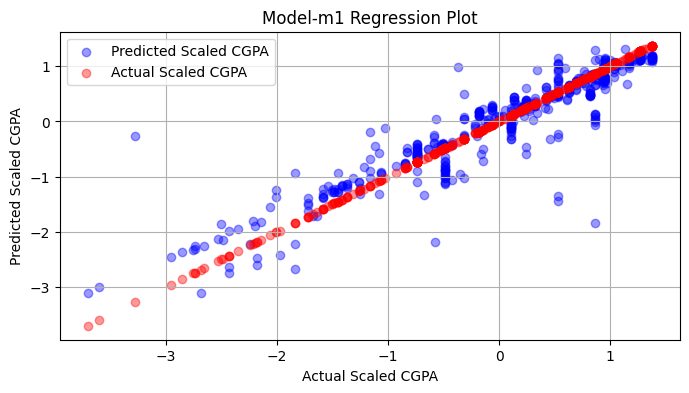

DEBUG:cmdstanpy:Removing /content/academic_nonacademic_interaction_effects_model
05:31:17 - cmdstanpy - INFO - compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=academic_nonacademic_interaction_effects_model.stan /content/academic_nonacademic_interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0


R squared:  0.8594121387511501


DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=academic_nonacademic_interaction_effects_model.stan --o=/content/academic_nonacademic_interaction_effects_model.hpp /content/academic_nonacademic_interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/academic_nonacademic_interaction_effects_model.o /content/academic_nonacademic_interaction_effects_model.hpp

--- Linking model ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/0nj7kpft.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/0nj7kpft.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2


05:31:46 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/0nj7kpft.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_0-stdout.txt
DEBUG:cmdstanpy:Chain 1

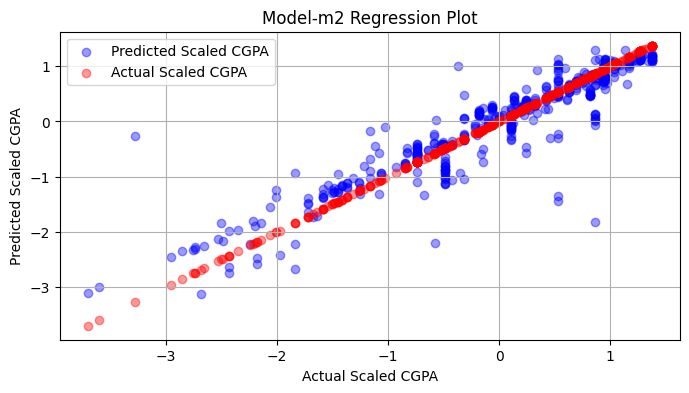

DEBUG:cmdstanpy:Removing /content/academic_nonacademic_interaction_effects_model
05:31:47 - cmdstanpy - INFO - compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=academic_nonacademic_interaction_effects_model.stan /content/academic_nonacademic_interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0


R squared:  0.8594764693651893


DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=academic_nonacademic_interaction_effects_model.stan --o=/content/academic_nonacademic_interaction_effects_model.hpp /content/academic_nonacademic_interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/academic_nonacademic_interaction_effects_model.o /content/academic_nonacademic_interaction_effects_model.hpp

--- Linking model ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/r1kn6yt2.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/r1kn6yt2.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2


05:32:21 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/r1kn6yt2.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_0-stdout.txt
DEBUG:cmdstanpy:Chain 1

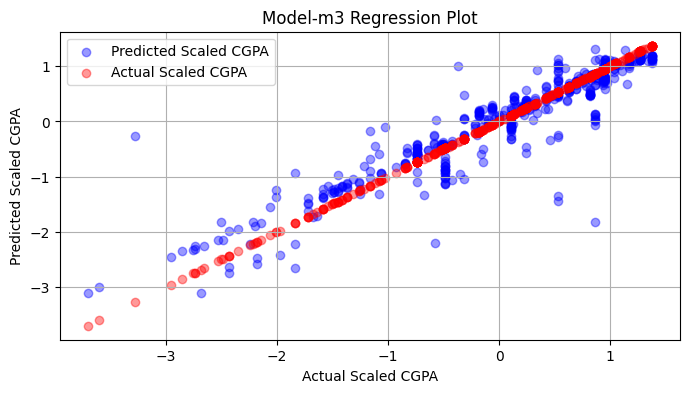

DEBUG:cmdstanpy:Removing /content/academic_nonacademic_interaction_effects_model
05:32:22 - cmdstanpy - INFO - compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=academic_nonacademic_interaction_effects_model.stan /content/academic_nonacademic_interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0


R squared:  0.8595199141704146


DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=academic_nonacademic_interaction_effects_model.stan --o=/content/academic_nonacademic_interaction_effects_model.hpp /content/academic_nonacademic_interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/academic_nonacademic_interaction_effects_model.o /content/academic_nonacademic_interaction_effects_model.hpp

--- Linking model ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/sz_b31ij.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/sz_b31ij.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2


05:33:06 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/sz_b31ij.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_0-stdout.txt
DEBUG:cmdstanpy:Chain 1

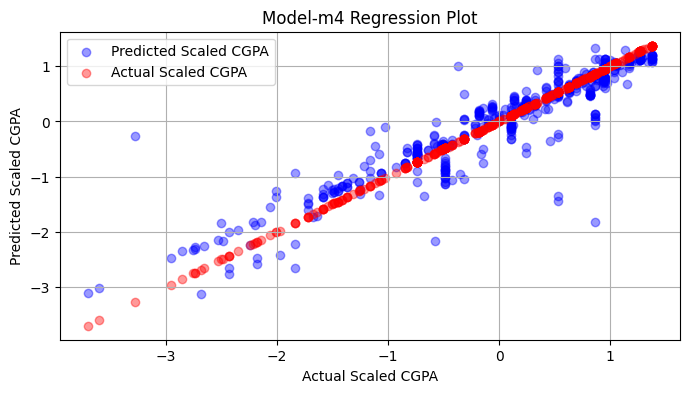

DEBUG:cmdstanpy:Removing /content/academic_nonacademic_interaction_effects_model
05:33:06 - cmdstanpy - INFO - compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=academic_nonacademic_interaction_effects_model.stan /content/academic_nonacademic_interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0


R squared:  0.85959826695833


DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=academic_nonacademic_interaction_effects_model.stan --o=/content/academic_nonacademic_interaction_effects_model.hpp /content/academic_nonacademic_interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/academic_nonacademic_interaction_effects_model.o /content/academic_nonacademic_interaction_effects_model.hpp

--- Linking model ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/g8nxybko.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/g8nxybko.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2


05:33:51 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/g8nxybko.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_0-stdout.txt
DEBUG:cmdstanpy:Chain 1

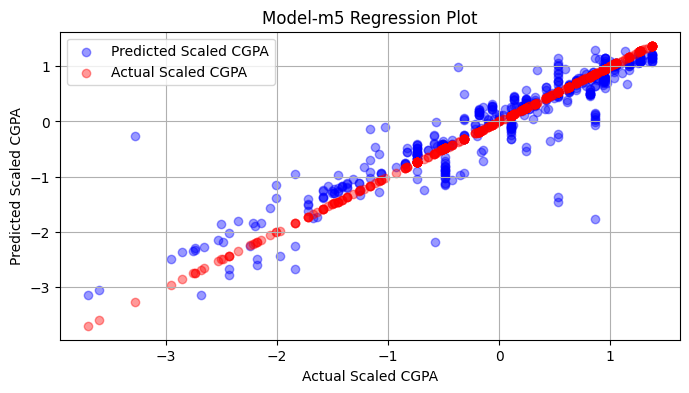

DEBUG:cmdstanpy:Removing /content/academic_nonacademic_interaction_effects_model
05:33:52 - cmdstanpy - INFO - compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=academic_nonacademic_interaction_effects_model.stan /content/academic_nonacademic_interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0


R squared:  0.8598974685825944


DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=academic_nonacademic_interaction_effects_model.stan --o=/content/academic_nonacademic_interaction_effects_model.hpp /content/academic_nonacademic_interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/academic_nonacademic_interaction_effects_model.o /content/academic_nonacademic_interaction_effects_model.hpp

--- Linking model ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/ddmxn2w2.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/ddmxn2w2.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2


05:34:38 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/ddmxn2w2.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_0-stdout.txt
DEBUG:cmdstanpy:Chain 1

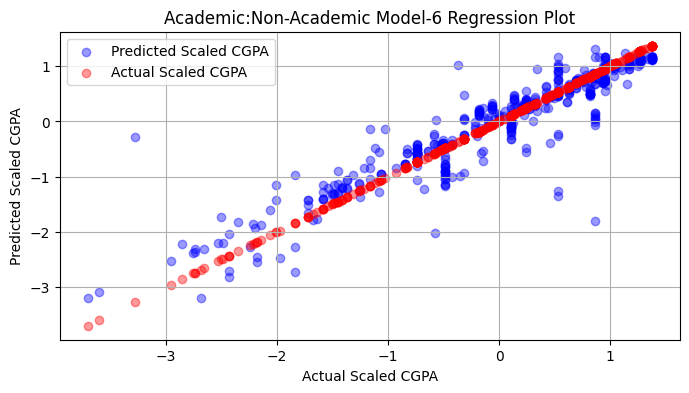

DEBUG:cmdstanpy:Removing /content/academic_nonacademic_interaction_effects_model
05:34:39 - cmdstanpy - INFO - compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=academic_nonacademic_interaction_effects_model.stan /content/academic_nonacademic_interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0


R squared:  0.8607719003224982


DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=academic_nonacademic_interaction_effects_model.stan --o=/content/academic_nonacademic_interaction_effects_model.hpp /content/academic_nonacademic_interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/academic_nonacademic_interaction_effects_model.o /content/academic_nonacademic_interaction_effects_model.hpp

--- Linking model ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/169fss62.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/169fss62.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2


05:35:27 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/169fss62.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_0-stdout.txt
DEBUG:cmdstanpy:Chain 1

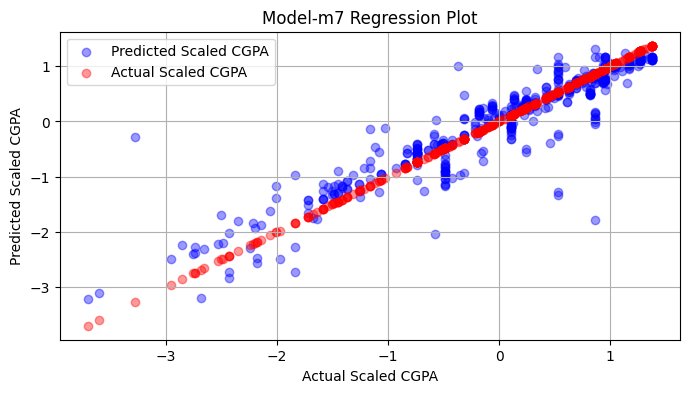

DEBUG:cmdstanpy:Removing /content/academic_nonacademic_interaction_effects_model
05:35:28 - cmdstanpy - INFO - compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=academic_nonacademic_interaction_effects_model.stan /content/academic_nonacademic_interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0


R squared:  0.8608245035044526


DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=academic_nonacademic_interaction_effects_model.stan --o=/content/academic_nonacademic_interaction_effects_model.hpp /content/academic_nonacademic_interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/academic_nonacademic_interaction_effects_model.o /content/academic_nonacademic_interaction_effects_model.hpp

--- Linking model ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/r_0lo_55.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/r_0lo_55.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2


05:36:16 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/r_0lo_55.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_0-stdout.txt
DEBUG:cmdstanpy:Chain 1

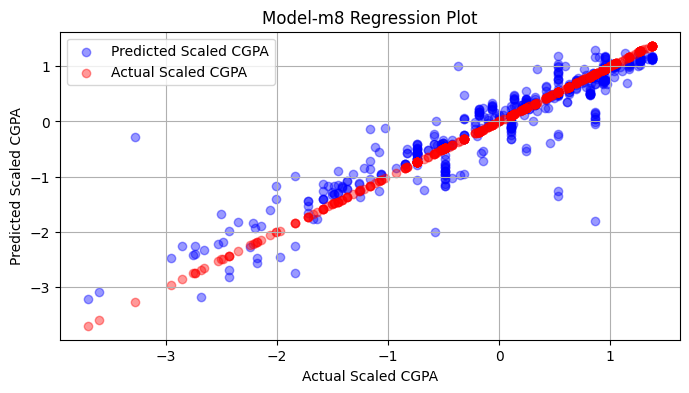

DEBUG:cmdstanpy:Removing /content/academic_nonacademic_interaction_effects_model
05:36:17 - cmdstanpy - INFO - compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
INFO:cmdstanpy:compiling stan file /content/academic_nonacademic_interaction_effects_model.stan to exe file /content/academic_nonacademic_interaction_effects_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=academic_nonacademic_interaction_effects_model.stan /content/academic_nonacademic_interaction_effects_model
cwd: /root/.cmdstan/cmdstan-2.36.0


R squared:  0.8608713953358577


DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=academic_nonacademic_interaction_effects_model.stan --o=/content/academic_nonacademic_interaction_effects_model.hpp /content/academic_nonacademic_interaction_effects_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/academic_nonacademic_interaction_effects_model.o /content/academic_nonacademic_interaction_effects_model.hpp

--- Linking model ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/1mxwch5s.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/academic_nonacademic_interaction_effects_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/1mxwch5s.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2


05:37:13 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/academic_nonacademic_interaction_effects_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmphw84p3wo/1mxwch5s.json', 'output', 'file=/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_1.csv
 console_msgs (if any):
	/tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_0-stdout.txt
DEBUG:cmdstanpy:Chain 1

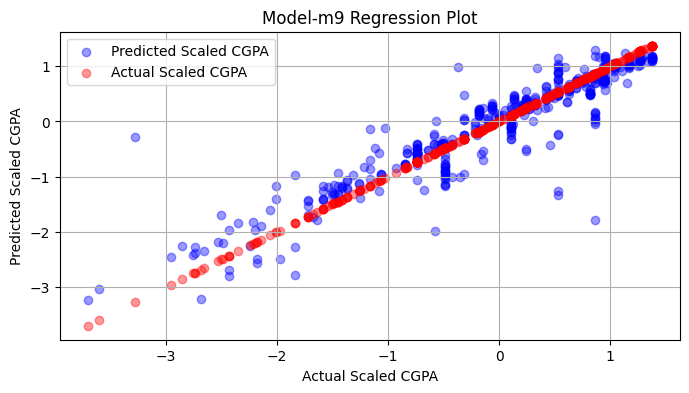

R squared:  0.8609669025184744


In [ ]:
from patsy import dmatrix

X_1 = dmatrix('~ 0 + Preparation + Last + Gender_Male + Computer + English + Gaming + Extra_Yes',data, return_type='dataframe')
X_2 = dmatrix('~ 0 + Preparation + Last + Gender_Male + Computer + English + Gaming + Extra_Yes + Preparation:Gender_Male',data, return_type='dataframe')
X_3 = dmatrix('~ 0 + Preparation + Last + Gender_Male + Computer + English + Gaming + Extra_Yes + Preparation:Gender_Male + Preparation:Computer',data, return_type='dataframe')
X_4 = dmatrix('~ 0 + Preparation + Last + Gender_Male + Computer + English + Gaming + Extra_Yes + Preparation:Gender_Male + Preparation:Computer + Preparation:English',data, return_type='dataframe')
X_5 = dmatrix('~ 0 + Preparation + Last + Gender_Male + Computer + English + Gaming + Extra_Yes + Preparation:Gender_Male + Preparation:Computer + Preparation:English + Last:Gaming',data, return_type='dataframe')
X_6 = dmatrix('~ 0 + Preparation + Last + Gender_Male + Computer + English + Gaming + Extra_Yes + Preparation:Gender_Male + Preparation:Computer + Preparation:English + Last:Gaming +  Last:Gender_Male',data, return_type='dataframe')
X_7 = dmatrix('~ 0 + Preparation + Last + Gender_Male + Computer + English + Gaming + Extra_Yes + Preparation:Gender_Male + Preparation:Computer + Preparation:English + Last:Gaming +  Last:Gender_Male + Last:Extra_Yes',data, return_type='dataframe')
X_8 = dmatrix('~ 0 + Preparation + Last + Gender_Male + Computer + English + Gaming + Extra_Yes + Preparation:Gender_Male + Preparation:Computer + Preparation:English + Last:Gaming +  Last:Gender_Male + Last:Extra_Yes + Last:English',data, return_type='dataframe')
X_9 = dmatrix('~ 0 + Preparation + Last + Gender_Male + Computer + English + Gaming + Extra_Yes + Preparation:Gender_Male + Preparation:Computer + Preparation:English + Last:Gaming +  Last:Gender_Male + Last:Extra_Yes + Last:English + Last:Computer',data, return_type='dataframe')

models = {"m1": X_1, "m2": X_2, "m3": X_3, "m4":X_4, "m5":X_5, "m6":X_6, "m7":X_7, "m8":X_8, "m9":X_9}
model_fits = []
m_regression_coeffs = {}

for model_name, model_X in models.items():
    fit = stan_fit(X = model_X, data = data)

    model_fits.append(fit)

    posterior_samples = fit.draws_pd()       #posterior samples

    # Extract posterior means for coefficients and intercept
    beta_means = posterior_samples[[col for col in posterior_samples.columns if "beta" in col]].mean().values
    alpha_mean = posterior_samples["alpha"].mean()

    m_regression_coeffs[model_name] = [np.round(alpha_mean,3), np.round(beta_means,3)]


    # Compute predicted GPA using the regression formula
    pred_overall = model_X.dot(beta_means) + alpha_mean

    if model_name == "m6":
        plot_regression("Academic:Non-Academic Model-6 Regression Plot", data = data, pred_overall = pred_overall)
    else:
        plot_regression("Model-"+model_name+" Regression Plot", data = data, pred_overall = pred_overall)

    R_squared = Rsquared(y_pred = pred_overall, y_true = data["Overall_scaled"])

    R_squared_vals[model_name] = round(R_squared,3)

    print("R squared: ", R_squared)


In [ ]:
i = 0
for fit in model_fits:
    i = i+1
    print("Fit summary for model", i)
    print(fit.summary())
    fit.summary().to_csv("sequential_stan_results"+str(i)+".csv")

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-4kvbg_b6.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_4.csv
cwd: None


Fit summary for model 1


DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-m0fxb3n_.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5myu_utd/academic_nonacademic_interaction_effects_model-20250328053108_4.csv
cwd: None


               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__     231.588000  0.033336  2.115880  2.022270  227.628000  231.904000   
alpha     -0.104653  0.001651  0.112917  0.114230   -0.288445   -0.105568   
beta[1]    0.067564  0.000390  0.029187  0.029050    0.019249    0.067670   
beta[2]    0.894457  0.000277  0.021512  0.021697    0.859417    0.894635   
beta[3]   -0.050033  0.000411  0.036907  0.036711   -0.112154   -0.049972   
beta[4]    0.012035  0.000170  0.014265  0.014350   -0.010985    0.011879   
beta[5]   -0.010320  0.000281  0.021758  0.021344   -0.046176   -0.010563   
beta[6]   -0.000298  0.000417  0.030433  0.030659   -0.050308   -0.000525   
beta[7]    0.056946  0.000427  0.037139  0.037112   -0.005206    0.057056   
sigma      0.379083  0.000136  0.011945  0.011923    0.359880    0.378810   

                95%  ESS_bulk  ESS_tail     R_hat  
lp__     234.458000   4001.45   5712.23  1.000160  
alpha      0.081298   4673.66   5159.82  1.00107

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-c_s0r04h.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_4.csv
cwd: None


Fit summary for model 2


DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-6i83440o.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model9a_1b8o5/academic_nonacademic_interaction_effects_model-20250328053135_4.csv
cwd: None


               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__     231.227000  0.037482  2.249320  2.131240  227.111000  231.562000   
alpha     -0.078386  0.001763  0.122026  0.122500   -0.280602   -0.078029   
beta[1]    0.052510  0.000667  0.042874  0.042771   -0.017718    0.052720   
beta[2]    0.893834  0.000258  0.021275  0.020993    0.858786    0.894078   
beta[3]   -0.093854  0.001606  0.100591  0.101671   -0.258402   -0.093834   
beta[4]    0.011986  0.000162  0.014051  0.014237   -0.011519    0.012150   
beta[5]   -0.010136  0.000285  0.022001  0.022022   -0.046276   -0.010085   
beta[6]   -0.000060  0.000392  0.030301  0.029693   -0.050830    0.000373   
beta[7]    0.056389  0.000424  0.037211  0.037120   -0.004533    0.056079   
beta[8]    0.025796  0.000880  0.054830  0.055271   -0.064228    0.025091   
sigma      0.379396  0.000140  0.012314  0.012534    0.359848    0.379140   

                95%  ESS_bulk  ESS_tail     R_hat  
lp__     234.268000   3

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-2krj0fof.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_4.csv
cwd: None


Fit summary for model 3


DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-8egmkigx.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelhh5pjak0/academic_nonacademic_interaction_effects_model-20250328053205_4.csv
cwd: None


               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__     230.757000  0.040376  2.353550  2.220930  226.402000  231.097000   
alpha     -0.044399  0.002695  0.159307  0.157518   -0.306794   -0.043722   
beta[1]    0.030921  0.001333  0.074062  0.073021   -0.090027    0.030648   
beta[2]    0.893742  0.000274  0.021324  0.021451    0.858721    0.893725   
beta[3]   -0.087907  0.001623  0.103753  0.102907   -0.257591   -0.087276   
beta[4]   -0.001099  0.000665  0.037468  0.037734   -0.062689   -0.001216   
beta[5]   -0.009447  0.000265  0.022438  0.022515   -0.046923   -0.009210   
beta[6]   -0.000060  0.000396  0.030634  0.030059   -0.049932   -0.000070   
beta[7]    0.055569  0.000407  0.037342  0.036735   -0.005224    0.055262   
beta[8]    0.022464  0.000884  0.056838  0.056470   -0.071322    0.022504   
beta[9]    0.007717  0.000358  0.020123  0.019806   -0.025607    0.007619   
sigma      0.379432  0.000130  0.012001  0.012174    0.360483    0.379198   

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-eizn7fip.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_4.csv
cwd: None


Fit summary for model 4


DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-j6fnd48s.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model5dev6fn7/academic_nonacademic_interaction_effects_model-20250328053241_4.csv
cwd: None


                Mean      MCSE    StdDev       MAD          5%         50%  \
lp__      230.384000  0.045521  2.503540  2.405520  225.797000  230.719000   
alpha      -0.124199  0.003432  0.222647  0.224188   -0.492038   -0.126229   
beta[1]     0.076281  0.001825  0.116467  0.119641   -0.113284    0.076722   
beta[2]     0.893512  0.000234  0.021396  0.021281    0.858205    0.893253   
beta[3]    -0.084918  0.001387  0.103593  0.101791   -0.252239   -0.085911   
beta[4]    -0.007794  0.000543  0.040024  0.040151   -0.073277   -0.007403   
beta[5]     0.016891  0.000862  0.056051  0.057044   -0.075563    0.017045   
beta[6]     0.000566  0.000325  0.030521  0.031132   -0.049279    0.000578   
beta[7]     0.056083  0.000379  0.037709  0.037139   -0.006110    0.056085   
beta[8]     0.019651  0.000766  0.056629  0.055690   -0.073512    0.019945   
beta[9]     0.011410  0.000297  0.021741  0.021568   -0.024478    0.011096   
beta[10]   -0.015019  0.000461  0.029611  0.029743   -0.063418  

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-tk9n9irm.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_4.csv
cwd: None


Fit summary for model 5


DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-9g8p_as7.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modeln49g35xf/academic_nonacademic_interaction_effects_model-20250328053326_4.csv
cwd: None


                Mean      MCSE    StdDev       MAD          5%         50%  \
lp__      230.392000  0.048432  2.568640  2.510780  225.749000  230.685000   
alpha      -0.075640  0.003532  0.227483  0.227977   -0.447371   -0.073342   
beta[1]     0.080280  0.001845  0.116775  0.118834   -0.109237    0.080245   
beta[2]     0.805823  0.001244  0.091536  0.091102    0.654857    0.805928   
beta[3]    -0.089508  0.001382  0.104809  0.104724   -0.260009   -0.090140   
beta[4]    -0.005647  0.000541  0.039966  0.039377   -0.071027   -0.005926   
beta[5]     0.018738  0.000865  0.056262  0.056803   -0.073099    0.019187   
beta[6]    -0.016740  0.000421  0.035003  0.035105   -0.074340   -0.016894   
beta[7]     0.055033  0.000381  0.037385  0.037488   -0.006217    0.054881   
beta[8]     0.020400  0.000753  0.057000  0.056824   -0.074395    0.020806   
beta[9]     0.010199  0.000298  0.021805  0.021883   -0.026232    0.010373   
beta[10]   -0.016183  0.000461  0.029636  0.029527   -0.064519  

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-ai2vteqk.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_4.csv
cwd: None


Fit summary for model 6


DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-kd1qql5e.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_model37o071hp/academic_nonacademic_interaction_effects_model-20250328053411_4.csv
cwd: None


                Mean      MCSE    StdDev       MAD          5%         50%  \
lp__      231.374000  0.051263  2.654040  2.619010  226.502000  231.676000   
alpha      -0.020894  0.003779  0.230082  0.230787   -0.401421   -0.020258   
beta[1]     0.063101  0.001934  0.116988  0.116300   -0.131538    0.063233   
beta[2]     0.749151  0.001354  0.097306  0.096792    0.590261    0.747782   
beta[3]    -0.042753  0.001467  0.105168  0.103788   -0.214879   -0.043221   
beta[4]    -0.010042  0.000599  0.040956  0.040990   -0.078975   -0.010165   
beta[5]     0.004697  0.000926  0.057091  0.057405   -0.088547    0.004284   
beta[6]    -0.021098  0.000434  0.035247  0.035125   -0.078943   -0.020985   
beta[7]     0.059718  0.000388  0.037596  0.037144   -0.003308    0.060051   
beta[8]    -0.012490  0.000812  0.058590  0.058269   -0.108544   -0.012568   
beta[9]     0.013231  0.000318  0.022221  0.022158   -0.022919    0.013278   
beta[10]   -0.009511  0.000502  0.030137  0.029715   -0.059489  

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-6ii626e1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_4.csv
cwd: None


Fit summary for model 7


DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-cfqet1ni.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelv6ojatse/academic_nonacademic_interaction_effects_model-20250328053459_4.csv
cwd: None


                Mean      MCSE    StdDev       MAD          5%         50%  \
lp__      231.008000  0.048640  2.823560  2.724280  225.910000  231.365000   
alpha      -0.023544  0.003615  0.228014  0.229118   -0.401225   -0.021639   
beta[1]     0.061648  0.001846  0.117085  0.118238   -0.129687    0.061076   
beta[2]     0.768194  0.001549  0.110395  0.111606    0.589017    0.767956   
beta[3]    -0.041151  0.001414  0.107466  0.105742   -0.216477   -0.040656   
beta[4]    -0.014186  0.000531  0.040188  0.040483   -0.078055   -0.014904   
beta[5]     0.007422  0.000895  0.056630  0.057414   -0.085659    0.007988   
beta[6]    -0.018509  0.000444  0.035950  0.036051   -0.076856   -0.018632   
beta[7]     0.062160  0.000354  0.037726  0.037801    0.000060    0.062314   
beta[8]    -0.013685  0.000790  0.059748  0.058518   -0.112972   -0.013775   
beta[9]     0.015265  0.000288  0.021757  0.021892   -0.021037    0.015611   
beta[10]   -0.010917  0.000469  0.029566  0.029967   -0.059431  

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-x4812n5g.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_4.csv
cwd: None


Fit summary for model 8


DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-r4h2dkax.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelz5pr7v7m/academic_nonacademic_interaction_effects_model-20250328053547_4.csv
cwd: None


                Mean      MCSE    StdDev       MAD          5%         50%  \
lp__      230.531000  0.052438  2.854420  2.740590  225.241000  230.858000   
alpha      -0.042114  0.003708  0.233251  0.232824   -0.430052   -0.039205   
beta[1]     0.072267  0.001916  0.119358  0.120114   -0.121152    0.071592   
beta[2]     0.750529  0.001577  0.116736  0.117815    0.558925    0.750324   
beta[3]    -0.047338  0.001375  0.107677  0.106090   -0.221074   -0.048801   
beta[4]    -0.012751  0.000553  0.040682  0.041358   -0.079111   -0.012523   
beta[5]     0.011558  0.000979  0.058285  0.057787   -0.082397    0.010868   
beta[6]    -0.017483  0.000454  0.036193  0.035977   -0.076648   -0.017973   
beta[7]     0.061136  0.000335  0.037372  0.037434   -0.001145    0.061392   
beta[8]    -0.010435  0.000770  0.059972  0.059470   -0.110761   -0.010433   
beta[9]     0.014668  0.000309  0.022107  0.022329   -0.022258    0.014863   
beta[10]   -0.013791  0.000531  0.030926  0.030848   -0.064847  

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-qcbt5dg3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_4.csv
cwd: None


Fit summary for model 9


DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmphw84p3wo/stansummary-academic_nonacademic_interaction_effects_model-op95_53g.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_1.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_2.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_3.csv /tmp/tmphw84p3wo/academic_nonacademic_interaction_effects_modelrxy56aoe/academic_nonacademic_interaction_effects_model-20250328053637_4.csv
cwd: None


                Mean      MCSE    StdDev       MAD          5%         50%  \
lp__      230.212000  0.051393  2.968670  2.891070  224.862000  230.560000   
alpha      -0.017706  0.003574  0.235087  0.236992   -0.405490   -0.018264   
beta[1]     0.061469  0.001869  0.120171  0.120826   -0.134999    0.061191   
beta[2]     0.767484  0.001642  0.120886  0.119789    0.568692    0.767101   
beta[3]    -0.040739  0.001433  0.107992  0.108749   -0.216780   -0.040983   
beta[4]    -0.022438  0.000638  0.043661  0.043539   -0.094855   -0.022201   
beta[5]     0.013071  0.000905  0.058121  0.057526   -0.084235    0.013181   
beta[6]    -0.017820  0.000435  0.036241  0.036013   -0.077624   -0.017828   
beta[7]     0.060425  0.000346  0.038231  0.037822   -0.002481    0.060562   
beta[8]    -0.014423  0.000822  0.060493  0.061127   -0.113750   -0.013795   
beta[9]     0.020200  0.000349  0.023870  0.023927   -0.019143    0.020042   
beta[10]   -0.015164  0.000498  0.031182  0.031016   -0.066659  

# Comparing Models using AIC/BIC and Leave One out Cross Validation

In [ ]:
def compute_log_likelihood(y_true, y_pred, sigma, return_individual=False):
    # Compute per-observation log-likelihood
    individual_ll = -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((y_true - y_pred)**2 / sigma**2)
    if return_individual:
        return individual_ll
    else:
        return np.sum(individual_ll)

def compute_aic_bic(stan_fit, data, y_col, X_cols):
    # Extract posterior samples as a DataFrame.
    posterior_samples = stan_fit.draws_pd()

    # Compute posterior means.
    alpha_mean = posterior_samples["alpha"].mean()
    sigma_mean = posterior_samples["sigma"].mean()
    beta_cols = [c for c in posterior_samples.columns if c.startswith("beta")]
    beta_means = posterior_samples[beta_cols].mean().values

    # Prepare data.
    X = data[X_cols].values  # shape (n_obs, n_predictors)
    y = data[y_col].values   # shape (n_obs,)

    # Compute predicted values using the posterior means.
    y_pred = alpha_mean + X.dot(beta_means)

    # Compute the total log-likelihood.
    total_log_lik = compute_log_likelihood(y, y_pred, sigma_mean, return_individual=False)

    n = len(y)
    # Number of parameters: beta's + alpha + sigma.
    k = len(beta_means) + 2

    # AIC and BIC formulas.
    aic = 2 * k - 2 * total_log_lik
    bic = k * np.log(n) - 2 * total_log_lik
    return aic, bic

def compute_aic_bic_dmatrix(stan_fit, X_design, y):
    # Extract posterior samples as a DataFrame.
    posterior_samples = stan_fit.draws_pd()

    # Compute posterior means.
    alpha_mean = posterior_samples["alpha"].mean()
    sigma_mean = posterior_samples["sigma"].mean()

    # Identify beta columns (assuming they are named 'beta[1]', 'beta[2]', etc.)
    beta_cols = [c for c in posterior_samples.columns if c.startswith("beta")]
    beta_means = posterior_samples[beta_cols].mean().values

    # Compute predicted values using the posterior means.
    y_pred = alpha_mean + X_design.dot(beta_means)

    # Compute the total log-likelihood.
    total_log_lik = compute_log_likelihood(y, y_pred, sigma_mean, return_individual=False)

    n = len(y)
    # Number of parameters: beta's + alpha + sigma.
    k = len(beta_means) + 2

    # AIC and BIC formulas.
    aic = 2 * k - 2 * total_log_lik
    bic = k * np.log(n) - 2 * total_log_lik
    return aic, bic

def compute_log_lik_array(fit, data, y_col, X_cols):
    posterior_samples = fit.draws_pd()
    n_draws = len(posterior_samples)

    # Prepare data.
    X = data[X_cols].values
    y = data[y_col].values
    n_obs = len(y)

    beta_cols = [col for col in posterior_samples.columns if col.startswith("beta")]
    log_lik_array = np.empty((n_draws, n_obs))

    # Loop over each posterior draw.
    for i, row in posterior_samples.iterrows():
        alpha = row["alpha"]
        sigma = row["sigma"]
        beta = row[beta_cols].values
        y_pred = alpha + X.dot(beta)
        # Get per-observation log-likelihood.
        log_lik_array[i, :] = compute_log_likelihood(y, y_pred, sigma, return_individual=True)

    # If chain information is available, reshape accordingly.
    try:
        n_chains = int(fit.runset.chains)
        n_samples = n_draws // n_chains
        log_lik_array = log_lik_array.reshape((n_chains, n_samples, n_obs))
    except Exception:
        # If chain info is not available, leave it as (n_draws, n_obs)
        pass

    return log_lik_array

def get_inference_data(fit, data, y_col, X_cols):
    posterior_samples = fit.draws_pd().to_dict(orient="list")
    log_lik_array = compute_log_lik_array(fit, data, y_col, X_cols)
    idata = az.from_dict(
        posterior=posterior_samples,
        log_likelihood={"log_lik": log_lik_array}
    )
    return idata


In [ ]:
#Full
full_aic, full_bic = compute_aic_bic(
    stan_fit = fit_full,
    data     = data,
    y_col    = "Overall_scaled",
    X_cols   = [col for col in data.columns
                if col not in ( "Overall_scaled")]
)

print("Full AIC:", full_aic)
print("Full BIC:", full_bic)
#Academic
academic_aic, academic_bic = compute_aic_bic(
    stan_fit = fit_academic,
    data     = data_academic,
    y_col    = "Overall_scaled",
    X_cols   = [col for col in data_academic.columns
                if col not in ( "Overall_scaled")]
)
print("Academic AIC:", academic_aic)
print("Academic BIC:", academic_bic)
#Academic Inter
academic_inter_aic, academic_inter_bic = compute_aic_bic_dmatrix(fit_academic_inter, X_design=X_ac, y=data_academic["Overall_scaled"])

print("Academic-interaction AIC:", academic_inter_aic)
print("Academic-Interaction BIC:", academic_inter_bic)
#non-Acdemic
non_academic_aic, non_academic_bic = compute_aic_bic(
    stan_fit = fit_non_academic,
    data     = data_non_academic,
    y_col    = "Overall_scaled",
    X_cols   = [col for col in data_non_academic.columns
                if col not in ( "Overall_scaled")]
)
print("Non-Academic AIC:", non_academic_aic)
print("Non-Academic BIC:", non_academic_bic)

#Non academic interaction
non_academic_inter_aic, non_academic_inter_bic = compute_aic_bic_dmatrix(fit_non_acad_inter, X_design=X_nac, y=data_non_academic["Overall_scaled"])

print("Non-Academic inter AIC:", non_academic_inter_aic)
print("Non-Academic inter BIC:", non_academic_inter_bic)
'''
X_cols = [col for col in data.columns if col not in ("Overall_scaled", "Intercept")]
X = data[X_cols]
#fit = stan_fit(X, data)
ac_nonac_interactive_aic, ac_nonac_interactive_bic = compute_aic_bic(
    stan_fit=fit,
    data=data,
    y_col="Overall_scaled",
    X_cols=X_cols
)

print("Academic:Non-Academic AIC:", ac_nonac_interactive_aic)
print("Academic:Non-Academic BIC:", ac_nonac_interactive_bic)
'''
#best
fit_m6 = model_fits[list(models.keys()).index("m6")]
aic, bic = compute_aic_bic_dmatrix(fit_m6, X_design=X_6, y=data["Overall_scaled"])
print("Best Academic:Non-Academic AIC:", aic)
print("Best Academic:Non-Academic BIC:", bic)


Full AIC: 459.70141686786735
Full BIC: 526.9095636525503
Academic AIC: 449.3039380110788
Academic BIC: 482.90801140342035
Academic-interaction AIC: 436.4161564833017
Academic-Interaction BIC: 470.02022987564317
Non-Academic AIC: 1253.6606910949072
Non-Academic BIC: 1295.665782835334
Non-Academic inter AIC: 1234.865686764594
Non-Academic inter BIC: 1289.472306027149
Best Academic:Non-Academic AIC: 455.31142884698113
Best Academic:Non-Academic BIC: 514.1185572835788


In [ ]:
#For Full
data_full = data[predictor_cols].copy()
data_full["Overall_scaled"] = data["Overall_scaled"]

idata_full = get_inference_data(
    fit=fit_full,
    data=data_full,
    y_col="Overall_scaled",
    X_cols=predictor_cols
)
loo_full = az.loo(idata_full)
print("LOO for Full Model:", loo_full)

# Academic Model
idata_academic = get_inference_data(
    fit=fit_academic,
    data=data_academic,
    y_col="Overall_scaled",
    X_cols=[col for col in data_academic.columns if col != "Overall_scaled"]
)
loo_academic = az.loo(idata_academic)
print("LOO for Academic Model:", loo_academic)

# academic interaction Model
# Create a DataFrame that contains the predictors (interaction terms) and the response.
academic_cols = X_ac.columns.tolist()
data_academic_interaction = X_ac.copy()
data_academic_interaction["Overall_scaled"] = data_academic["Overall_scaled"]
idata_academic_inter = get_inference_data(
    fit=fit_academic_inter,
    data=data_academic_interaction,
    y_col="Overall_scaled",
    X_cols=academic_cols
)
loo_academic_inter = az.loo(idata_academic_inter)
print("LOO for Academic interaction Model:", loo_academic_inter)

# non-academic
idata_non_academic = get_inference_data(
    fit=fit_non_academic,
    data=data_non_academic,
    y_col="Overall_scaled",
    X_cols=[col for col in data_non_academic.columns if col != "Overall_scaled"]
)
loo_non_academic = az.loo(idata_non_academic)
print("LOO for Non-Academic Model:", loo_non_academic)

# Non-Academic interaction Model
non_academic_cols = X_nac.columns.tolist()
data_non_academic_interaction = X_nac.copy()
data_non_academic_interaction["Overall_scaled"] = data_non_academic["Overall_scaled"]

idata_non_academic_inter = get_inference_data(
    fit=fit_non_acad_inter,
    data=data_non_academic_interaction,
    y_col="Overall_scaled",
    X_cols=non_academic_cols #extract list from dataframe
)
loo_non_academic_inter = az.loo(idata_non_academic_inter)
print("LOO for Non-Academic interaction Model:", loo_non_academic_inter)

#Best Academic and Non-academic

X_m6 = models["m6"]
academic_non_academic_cols = X_m6.columns.tolist()
data_academic_non_academic_interaction = X_m6.copy()
data_academic_non_academic_interaction["Overall_scaled"] = data["Overall_scaled"]
fit_m6 = model_fits[list(models.keys()).index("m6")]
idata_academic_non_academic_inter = get_inference_data(
    fit=fit_m6,
    data=data_academic_non_academic_interaction,
    y_col="Overall_scaled",
    X_cols=academic_non_academic_cols
)
loo_academic_non_academic_inter = az.loo(idata_academic_non_academic_inter)
print("LOO for Academic and Non-Academic interaction Model (m6):", loo_academic_non_academic_inter)


LOO for Full Model: Computed from 8000 posterior samples and 493 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -237.07    50.05
p_loo       28.34        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      491   99.6%
   (0.70, 1]   (bad)         2    0.4%
   (1, Inf)   (very bad)    0    0.0%

LOO for Academic Model: Computed from 8000 posterior samples and 493 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -231.46    50.67
p_loo       20.22        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      491   99.6%
   (0.70, 1]   (bad)         2    0.4%
   (1, Inf)   (very bad)    0    0.0%

LOO for Academic interaction Model: Computed from 8000 posterior samples and 493 observations lo

In [ ]:

model_dict = {
    "Model with all factors":idata_full,
    "Academic Model ":idata_academic,
    "Non-Academic Model":idata_non_academic,
    "Academic Interaction Model": idata_academic_inter,
    "Non Academic Interaction": idata_non_academic_inter,
    "Academic and Non-Academic Interaction": idata_academic_non_academic_inter
}

comparison = az.compare(model_dict, ic="loo")
print(comparison)


                                       rank    elpd_loo      p_loo  \
Academic Interaction Model                0 -225.444741  20.634344   
Academic Model                            1 -231.464787  20.218022   
Academic and Non-Academic Interaction     2 -235.409968  26.991316   
Model with all factors                    3 -237.067760  28.338442   
Non Academic Interaction                  4 -618.146821  13.904555   
Non-Academic Model                        5 -627.406924  10.788947   

                                        elpd_diff        weight         se  \
Academic Interaction Model               0.000000  3.426558e-01  49.201833   
Academic Model                           6.020045  6.337407e-01  50.665274   
Academic and Non-Academic Interaction    9.965227  0.000000e+00  49.352639   
Model with all factors                  11.623019  0.000000e+00  50.045641   
Non Academic Interaction               392.702080  1.701555e-14  21.944695   
Non-Academic Model                     40

# Result Summaries

In [ ]:
#Compare Model R squared values
print("R^2 values for each model:")
df_Rsquared = pd.DataFrame(R_squared_vals, index = [0])
df_Rsquared

R^2 values for each model:


,all_factors,academic,academic_inter,non_academic,non_academic_inter,m1,m2,m3,m4,m5,m6,m7,m8,m9
0,0.861,0.861,0.863,0.285,0.32,0.859,0.859,0.86,0.86,0.86,0.861,0.861,0.861,0.861


In [ ]:
# #Table for interactive sequence models
m_regression_coeffs

{'m1': [np.float64(-0.105),
  array([ 0.068,  0.894, -0.05 ,  0.012, -0.01 , -0.   ,  0.057])],
 'm2': [np.float64(-0.078),
  array([ 0.053,  0.894, -0.094,  0.012, -0.01 , -0.   ,  0.056,  0.026])],
 'm3': [np.float64(-0.044),
  array([ 0.031,  0.894, -0.088, -0.001, -0.009, -0.   ,  0.056,  0.022,
          0.008])],
 'm4': [np.float64(-0.124),
  array([ 0.076,  0.894, -0.085, -0.008,  0.017,  0.001,  0.056,  0.02 ,
          0.011, -0.015])],
 'm5': [np.float64(-0.076),
  array([ 0.08 ,  0.806, -0.09 , -0.006,  0.019, -0.017,  0.055,  0.02 ,
          0.01 , -0.016,  0.032])],
 'm6': [np.float64(-0.021),
  array([ 0.063,  0.749, -0.043, -0.01 ,  0.005, -0.021,  0.06 , -0.012,
          0.013, -0.01 ,  0.032,  0.075])],
 'm7': [np.float64(-0.024),
  array([ 0.062,  0.768, -0.041, -0.014,  0.007, -0.019,  0.062, -0.014,
          0.015, -0.011,  0.028,  0.074, -0.017])],
 'm8': [np.float64(-0.042),
  array([ 0.072,  0.751, -0.047, -0.013,  0.012, -0.017,  0.061, -0.01 ,
          0.01

In [ ]:
df_regression_coeffs = pd.DataFrame(m_regression_coeffs, index = ["alpha", "betas"])
df_regression_coeffs

,m1,m2,m3,m4,m5,m6,m7,m8,m9
alpha,-0.105,-0.078,-0.044,-0.124,-0.076,-0.021,-0.024,-0.042,-0.018
betas,"[0.068, 0.894, -0.05, 0.012, -0.01, -0.0, 0.057]","[0.053, 0.894, -0.094, 0.012, -0.01, -0.0, 0.0...","[0.031, 0.894, -0.088, -0.001, -0.009, -0.0, 0...","[0.076, 0.894, -0.085, -0.008, 0.017, 0.001, 0...","[0.08, 0.806, -0.09, -0.006, 0.019, -0.017, 0....","[0.063, 0.749, -0.043, -0.01, 0.005, -0.021, 0...","[0.062, 0.768, -0.041, -0.014, 0.007, -0.019, ...","[0.072, 0.751, -0.047, -0.013, 0.012, -0.017, ...","[0.061, 0.767, -0.041, -0.022, 0.013, -0.018, ..."
